In [ ]:
from google.colab import drive
import os
import glob
import shutil
import librosa

# Mount Google Drive
drive.mount('/content/drive')

# Set paths
original_dataset_path = "/content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/Respiratory_Sound_Database"
balanced_dataset_path = "/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database"
copd_balanced_path = os.path.join(balanced_dataset_path, "COPD")
healthy_balanced_path = os.path.join(balanced_dataset_path, "Healthy")

# Create directories if they don't exist
os.makedirs(copd_balanced_path, exist_ok=True)
os.makedirs(healthy_balanced_path, exist_ok=True)

# Get all .wav files from the original dataset
# Adjust naming convention based on your dataset; assuming files indicate COPD/Healthy
copd_files = glob.glob(os.path.join(original_dataset_path, "**/*.wav"), recursive=True)
healthy_files = glob.glob(os.path.join(original_dataset_path, "**/*.wav"), recursive=True)
# Filter files (example: assuming filenames or metadata distinguish COPD/Healthy)
# Since you mentioned 894 COPD and 26 Healthy files, we'll select based on available files
copd_files = [f for f in copd_files if "COPD" in f or any(id in f for id in ["COPD_patient_id"])]  # Adjust based on actual naming
healthy_files = [f for f in healthy_files if "Healthy" in f or any(id in f for id in ["Healthy_patient_id"])]  # Adjust based on actual naming

# Verify file counts
print(f"Found {len(copd_files)} COPD files and {len(healthy_files)} Healthy files in original dataset.")

# Copy 26 files for each class to the balanced folder
for i, file_path in enumerate(copd_files[:26]):
    dest_path = os.path.join(copd_balanced_path, f"COPD_{i+1}.wav")
    shutil.copy(file_path, dest_path)
    print(f"Copied COPD file: {os.path.basename(file_path)} to {dest_path}")

for i, file_path in enumerate(healthy_files[:26]):
    dest_path = os.path.join(healthy_balanced_path, f"Healthy_{i+1}.wav")
    shutil.copy(file_path, dest_path)
    print(f"Copied Healthy file: {os.path.basename(file_path)} to {dest_path}")

# Verify copied files
copd_copied = glob.glob(os.path.join(copd_balanced_path, "*.wav"))
healthy_copied = glob.glob(os.path.join(healthy_balanced_path, "*.wav"))

print(f"\nVerification:")
print(f"COPD files in balanced folder: {len(copd_copied)}")
print(f"Healthy files in balanced folder: {len(healthy_copied)}")
print("\nSample COPD files:")
for file in copd_copied[:5]:
    print(file)
print("\nSample Healthy files:")
for file in healthy_copied[:5]:
    print(file)

# Check file format
def verify_wav(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        print(f"File {os.path.basename(file_path)}: Sample rate = {sr}, Duration = {len(y)/sr:.2f}s")
        return True
    except Exception as e:
        print(f"Error loading {os.path.basename(file_path)}: {e}")
        return False

print("\nVerifying file formats:")
for file in copd_copied[:2] + healthy_copied[:2]:
    verify_wav(file)

Mounted at /content/drive
Found 0 COPD files and 0 Healthy files in original dataset.

Verification:
COPD files in balanced folder: 26
Healthy files in balanced folder: 26

Sample COPD files:
/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/COPD/110_1p1_Pr_sc_Meditron.wav
/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/COPD/110_1b1_Pr_sc_Meditron.wav
/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/COPD/110_1p1_Ll_sc_Meditron.wav
/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/COPD/110_1p1_Lr_sc_Meditron.wav
/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/COPD/110_1p1_Al_sc_Meditron.wav

Sample Healthy files:
/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/Healthy/102_1b1_Ar_sc_Meditron.wav
/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/Healthy/121_1b1_Tc_sc_Meditron.wav
/content/drive/MyDrive/KaggleDatasets

In [ ]:
!pip install librosa numpy pywt scikit-learn matplotlib

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 58.0 MB/s eta 0:00:00
Found 26 COPD files and 26 Healthy files in balanced dataset.
Original MFCC + Wavelet Features Shape: (52, 65)
Labels Shape: (52,)
Selected Features Shape: (52, 40)


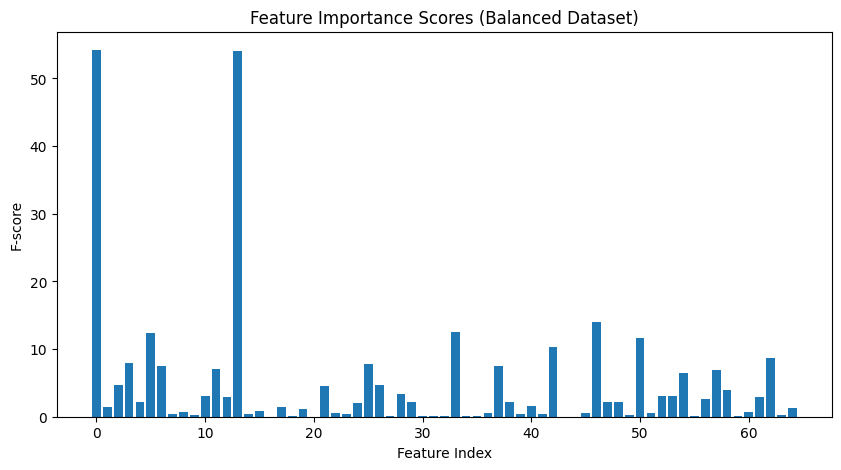

In [ ]:
# Install required libraries
!pip install librosa numpy PyWavelets scikit-learn matplotlib

import librosa
import numpy as np
import pywt
import os
import glob
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt

# Paths to balanced dataset
copd_folder = "/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/COPD/"
healthy_folder = "/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/Healthy/"

# Get .wav files
copd_files = glob.glob(os.path.join(copd_folder, "*.wav"))
healthy_files = glob.glob(os.path.join(healthy_folder, "*.wav"))

# Verify file counts
print(f"Found {len(copd_files)} COPD files and {len(healthy_files)} Healthy files in balanced dataset.")

# Initialize lists
mfcc_features = []
labels = []

# Function to extract MFCC and apply wavelet transformation
def extract_mfcc_wavelet(file_path, num_mfcc=13, wavelet='db4'):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Standardize sample rate
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Apply wavelet transformation to MFCC
        coeffs = []
        for i in range(mfcc.shape[0]):
            cA, cD = pywt.dwt(mfcc[i], wavelet=wavelet)
            coeffs.extend([np.mean(cA), np.std(cA), np.mean(cD), np.std(cD)])

        return np.concatenate([mfcc_mean, coeffs])
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None

# Process files
for file_path in copd_files:
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(1)  # COPD

for file_path in healthy_files:
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(0)  # Healthy

# Convert to NumPy arrays
mfcc_features = np.array(mfcc_features)
labels = np.array(labels)

# Check for valid data
if mfcc_features.shape[0] == 0:
    raise ValueError("No features extracted. Check audio files or extraction process.")

print("Original MFCC + Wavelet Features Shape:", mfcc_features.shape)
print("Labels Shape:", labels.shape)

# Feature selection
num_features = min(40, mfcc_features.shape[1])  # Select <52 features
selector = SelectKBest(score_func=f_classif, k=num_features)
mfcc_features_selected = selector.fit_transform(mfcc_features, labels)

print("Selected Features Shape:", mfcc_features_selected.shape)

# Visualize feature importance
scores = selector.scores_
plt.figure(figsize=(10, 5))
plt.bar(range(len(scores)), scores)
plt.title("Feature Importance Scores (Balanced Dataset)")
plt.xlabel("Feature Index")
plt.ylabel("F-score")
plt.show()

Found 26 COPD files and 26 Healthy files in balanced dataset.
Original MFCC + Wavelet Features Shape: (52, 65)
Labels Shape: (52,)
Selected Features Shape: (52, 40)

MFCC Features (Selected) and Labels:
     Feature_0   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0  -371.149139   74.442162  44.511242  25.555645  25.682110  31.604771   
1  -380.830170   78.642555  50.876629  29.429314  23.289114  25.387407   
2  -361.492310  102.020554  64.265305  35.754417  27.727659  29.188583   
3  -378.827911   78.934639  58.641777  40.502182  31.958183  30.722229   
4  -388.303253   71.428757  56.057674  43.527142  38.175499  35.793598   
5  -319.082733  121.842865  69.624161  38.592972  30.815840  28.414473   
6  -308.042664  134.050064  70.521103  35.042057  28.597540  26.902527   
7  -290.039001  108.084305  41.539402  39.187901  25.967186  27.564671   
8  -252.845581  102.980873  30.898994  35.699322  29.927902  29.399385   
9  -233.481155  143.391617  66.054688  45.482510  21.0780

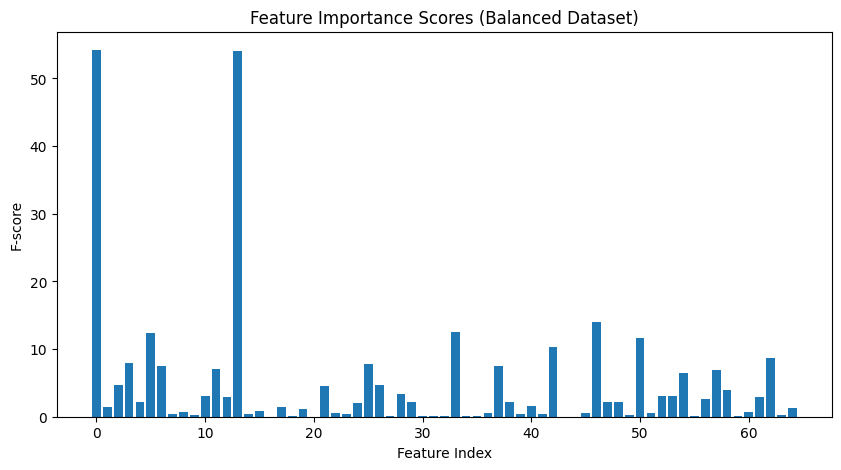

In [ ]:
# Install required libraries
!pip install librosa numpy PyWavelets scikit-learn pandas matplotlib

# Import libraries
import librosa
import numpy as np
import pywt
import os
import glob
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import matplotlib.pyplot as plt

# Paths to balanced dataset
copd_folder = "/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/COPD/"
healthy_folder = "/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/Healthy/"

# Get .wav files
copd_files = glob.glob(os.path.join(copd_folder, "*.wav"))
healthy_files = glob.glob(os.path.join(healthy_folder, "*.wav"))

# Verify file counts
print(f"Found {len(copd_files)} COPD files and {len(healthy_files)} Healthy files in balanced dataset.")

# Initialize lists
mfcc_features = []
labels = []

# Function to extract MFCC and apply wavelet transformation
def extract_mfcc_wavelet(file_path, num_mfcc=13, wavelet='db4'):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Standardize sample rate
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Apply wavelet transformation to MFCC
        coeffs = []
        for i in range(mfcc.shape[0]):
            cA, cD = pywt.dwt(mfcc[i], wavelet=wavelet)
            coeffs.extend([np.mean(cA), np.std(cA), np.mean(cD), np.std(cD)])

        return np.concatenate([mfcc_mean, coeffs])
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None

# Process files
for file_path in copd_files:
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(1)  # COPD

for file_path in healthy_files:
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(0)  # Healthy

# Convert to NumPy arrays
mfcc_features = np.array(mfcc_features)
labels = np.array(labels)

# Check for valid data
if mfcc_features.shape[0] == 0:
    raise ValueError("No features extracted. Check audio files or extraction process.")

print("Original MFCC + Wavelet Features Shape:", mfcc_features.shape)
print("Labels Shape:", labels.shape)

# Feature selection
num_features = min(40, mfcc_features.shape[1])  # Select <52 features
selector = SelectKBest(score_func=f_classif, k=num_features)
mfcc_features_selected = selector.fit_transform(mfcc_features, labels)

print("Selected Features Shape:", mfcc_features_selected.shape)

# Create DataFrame for display
feature_columns = [f"Feature_{i}" for i in range(mfcc_features_selected.shape[1])]
df = pd.DataFrame(mfcc_features_selected, columns=feature_columns)
df['Label'] = labels

# Display DataFrame
print("\nMFCC Features (Selected) and Labels:")
print(df)

# Save DataFrame to CSV for reference
df.to_csv('/content/mfcc_features_selected.csv', index=False)
print("\nSaved features and labels to '/content/mfcc_features_selected.csv'")

# Visualize feature importance
scores = selector.scores_
plt.figure(figsize=(10, 5))
plt.bar(range(len(scores)), scores)
plt.title("Feature Importance Scores (Balanced Dataset)")
plt.xlabel("Feature Index")
plt.ylabel("F-score")
plt.show()

Found 26 COPD files and 26 Healthy files in balanced dataset.
Original MFCC + Wavelet Features Shape: (52, 65)
Labels Shape: (52,)
Selected Features Shape: (52, 40)

Feature Composition Analysis:
Total Selected Features: 40
Number of MFCC Means: 11
Number of Wavelet Features: 29
Breakdown of Wavelet Features:
  mean(cA): 10
  std(cA): 8
  mean(cD): 3
  std(cD): 8

MFCC Features (Selected) and Labels:
     Feature_0   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0  -371.149139   74.442162  44.511242  25.555645  25.682110  31.604771   
1  -380.830170   78.642555  50.876629  29.429314  23.289114  25.387407   
2  -361.492310  102.020554  64.265305  35.754417  27.727659  29.188583   
3  -378.827911   78.934639  58.641777  40.502182  31.958183  30.722229   
4  -388.303253   71.428757  56.057674  43.527142  38.175499  35.793598   
5  -319.082733  121.842865  69.624161  38.592972  30.815840  28.414473   
6  -308.042664  134.050064  70.521103  35.042057  28.597540  26.902527   
7  -

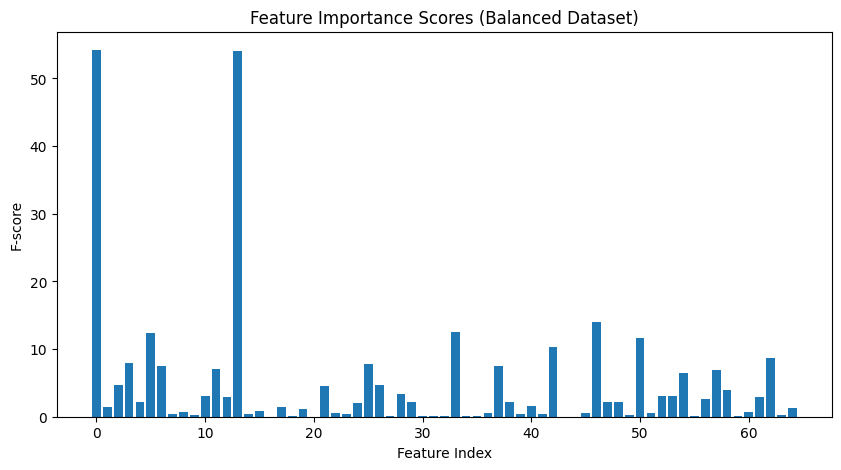

In [ ]:
# Install required libraries
!pip install librosa numpy PyWavelets scikit-learn pandas matplotlib

# Import libraries
import librosa
import numpy as np
import pywt
import os
import glob
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import matplotlib.pyplot as plt

# Paths to balanced dataset
copd_folder = "/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/COPD/"
healthy_folder = "/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/Healthy/"

# Get .wav files
copd_files = glob.glob(os.path.join(copd_folder, "*.wav"))
healthy_files = glob.glob(os.path.join(healthy_folder, "*.wav"))

# Verify file counts
print(f"Found {len(copd_files)} COPD files and {len(healthy_files)} Healthy files in balanced dataset.")

# Initialize lists
mfcc_features = []
labels = []

# Function to extract MFCC and apply wavelet transformation
def extract_mfcc_wavelet(file_path, num_mfcc=13, wavelet='db4'):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Standardize sample rate
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Apply wavelet transformation to MFCC
        coeffs = []
        for i in range(mfcc.shape[0]):
            cA, cD = pywt.dwt(mfcc[i], wavelet=wavelet)
            coeffs.extend([np.mean(cA), np.std(cA), np.mean(cD), np.std(cD)])

        return np.concatenate([mfcc_mean, coeffs])
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None

# Process files
for file_path in copd_files:
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(1)  # COPD

for file_path in healthy_files:
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(0)  # Healthy

# Convert to NumPy arrays
mfcc_features = np.array(mfcc_features)
labels = np.array(labels)

# Check for valid data
if mfcc_features.shape[0] == 0:
    raise ValueError("No features extracted. Check audio files or extraction process.")

print("Original MFCC + Wavelet Features Shape:", mfcc_features.shape)
print("Labels Shape:", labels.shape)

# Feature selection
num_features = min(40, mfcc_features.shape[1])  # Select <52 features
selector = SelectKBest(score_func=f_classif, k=num_features)
mfcc_features_selected = selector.fit_transform(mfcc_features, labels)

print("Selected Features Shape:", mfcc_features_selected.shape)

# Analyze selected features
selected_indices = selector.get_support(indices=True)
num_mfcc_means = sum(1 for idx in selected_indices if idx < 13)  # Indices 0-12 are MFCC means
num_wavelet = len(selected_indices) - num_mfcc_means  # Remaining are wavelet features

# Break down wavelet features
wavelet_mean_ca = 0
wavelet_std_ca = 0
wavelet_mean_cd = 0
wavelet_std_cd = 0

for idx in selected_indices:
    if idx >= 13:  # Wavelet features start at index 13
        wavelet_idx = idx - 13
        wavelet_type = wavelet_idx % 4
        if wavelet_type == 0:  # mean(cA)
            wavelet_mean_ca += 1
        elif wavelet_type == 1:  # std(cA)
            wavelet_std_ca += 1
        elif wavelet_type == 2:  # mean(cD)
            wavelet_mean_cd += 1
        elif wavelet_type == 3:  # std(cD)
            wavelet_std_cd += 1

# Print analysis
print("\nFeature Composition Analysis:")
print(f"Total Selected Features: {len(selected_indices)}")
print(f"Number of MFCC Means: {num_mfcc_means}")
print(f"Number of Wavelet Features: {num_wavelet}")
print("Breakdown of Wavelet Features:")
print(f"  mean(cA): {wavelet_mean_ca}")
print(f"  std(cA): {wavelet_std_ca}")
print(f"  mean(cD): {wavelet_mean_cd}")
print(f"  std(cD): {wavelet_std_cd}")

# Create DataFrame for display
feature_columns = [f"Feature_{i}" for i in range(mfcc_features_selected.shape[1])]
df = pd.DataFrame(mfcc_features_selected, columns=feature_columns)
df['Label'] = labels

# Display DataFrame
print("\nMFCC Features (Selected) and Labels:")
print(df)

# Save DataFrame to CSV for reference
df.to_csv('/content/mfcc_features_selected.csv', index=False)
print("\nSaved features and labels to '/content/mfcc_features_selected.csv'")

# Visualize feature importance
scores = selector.scores_
plt.figure(figsize=(10, 5))
plt.bar(range(len(scores)), scores)
plt.title("Feature Importance Scores (Balanced Dataset)")
plt.xlabel("Feature Index")
plt.ylabel("F-score")
plt.show()


In [ ]:
# Install required libraries
!pip install librosa numpy PyWavelets scikit-learn pandas matplotlib

# Import libraries
import librosa
import numpy as np
import pywt
import os
import glob
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import matplotlib.pyplot as plt

# Paths to balanced dataset
copd_folder = "/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/COPD/"
healthy_folder = "/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/Healthy/"

# Get .wav files
copd_files = glob.glob(os.path.join(copd_folder, "*.wav"))
healthy_files = glob.glob(os.path.join(healthy_folder, "*.wav"))

# Verify file counts
print(f"Found {len(copd_files)} COPD files and {len(healthy_files)} Healthy files in balanced dataset.")

# Initialize lists
mfcc_features = []
labels = []

# Function to extract MFCC and apply wavelet transformation
def extract_mfcc_wavelet(file_path, num_mfcc=13, wavelet='db4'):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Standardize sample rate
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Apply wavelet transformation to MFCC
        coeffs = []
        for i in range(mfcc.shape[0]):
            cA, cD = pywt.dwt(mfcc[i], wavelet=wavelet)
            coeffs.extend([np.mean(cA), np.std(cA), np.mean(cD), np.std(cD)])

        return np.concatenate([mfcc_mean, coeffs])
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None

# Process files
for file_path in copd_files:
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(1)  # COPD

for file_path in healthy_files:
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(0)  # Healthy

# Convert to NumPy arrays
mfcc_features = np.array(mfcc_features)
labels = np.array(labels)

# Check for valid data
if mfcc_features.shape[0] == 0:
    raise ValueError("No features extracted. Check audio files or extraction process.")

print("Original MFCC + Wavelet Features Shape:", mfcc_features.shape)
print("Labels Shape:", labels.shape)

# Feature selection with random_state for reproducibility
num_features = min(40, mfcc_features.shape[1])  # Select <52 features
selector = SelectKBest(score_func=f_classif, k=num_features, random_state=42)
mfcc_features_selected = selector.fit_transform(mfcc_features, labels)

print("Selected Features Shape:", mfcc_features_selected.shape)

# Analyze selected features
selected_indices = selector.get_support(indices=True)
num_mfcc_means = sum(1 for idx in selected_indices if idx < 13)  # Indices 0-12 are MFCC means
num_wavelet = len(selected_indices) - num_mfcc_means  # Remaining are wavelet features

# Break down wavelet features
wavelet_mean_ca = 0
wavelet_std_ca = 0
wavelet_mean_cd = 0
wavelet_std_cd = 0

for idx in selected_indices:
    if idx >= 13:  # Wavelet features start at index 13
        wavelet_idx = idx - 13
        wavelet_type = wavelet_idx % 4
        if wavelet_type == 0:  # mean(cA)
            wavelet_mean_ca += 1
        elif wavelet_type == 1:  # std(cA)
            wavelet_std_ca += 1
        elif wavelet_type == 2:  # mean(cD)
            wavelet_mean_cd += 1
        elif wavelet_type == 3:  # std(cD)
            wavelet_std_cd += 1

# Print analysis
print("\nFeature Composition Analysis:")
print(f"Total Selected Features: {len(selected_indices)}")
print(f"Number of MFCC Means: {num_mfcc_means}")
print(f"Number of Wavelet Features: {num_wavelet}")
print("Breakdown of Wavelet Features:")
print(f"  mean(cA): {wavelet_mean_ca}")
print(f"  std(cA): {wavelet_std_ca}")
print(f"  mean(cD): {wavelet_mean_cd}")
print(f"  std(cD): {wavelet_std_cd}")

# Create DataFrame for display
feature_columns = [f"Feature_{i}" for i in range(mfcc_features_selected.shape[1])]
df = pd.DataFrame(mfcc_features_selected, columns=feature_columns)
df['Label'] = labels

# Display DataFrame
print("\nMFCC Features (Selected) and Labels:")
print(df)

# Save DataFrame to CSV for reference
df.to_csv('/content/mfcc_features_selected.csv', index=False)
print("\nSaved features and labels to '/content/mfcc_features_selected.csv'")

# Visualize feature importance
scores = selector.scores_
plt.figure(figsize=(10, 5))
plt.bar(range(len(scores)), scores)
plt.title("Feature Importance Scores (Balanced Dataset)")
plt.xlabel("Feature Index")
plt.ylabel("F-score")
plt.show()

Found 26 COPD files and 26 Healthy files in balanced dataset.
Original MFCC + Wavelet Features Shape: (52, 65)
Labels Shape: (52,)


TypeError: SelectKBest.__init__() got an unexpected keyword argument 'random_state'

Found 26 COPD files and 26 Healthy files in balanced dataset.
Original MFCC + Wavelet Features Shape: (52, 65)
Labels Shape: (52,)
Selected Features Shape: (52, 40)

Selected Feature Indices: [ 0  1  2  3  4  5  6  8 10 11 12 13 15 17 19 21 24 25 26 28 29 33 37 38
 40 42 46 47 48 50 52 53 54 56 57 58 60 61 62 64]
Index 13: mean(cA) for MFCC 0
Index 15: mean(cD) for MFCC 0
Index 17: mean(cA) for MFCC 1
Index 19: mean(cD) for MFCC 1
Index 21: mean(cA) for MFCC 2
Index 24: std(cD) for MFCC 2
Index 25: mean(cA) for MFCC 3
Index 26: std(cA) for MFCC 3
Index 28: std(cD) for MFCC 3
Index 29: mean(cA) for MFCC 4
Index 33: mean(cA) for MFCC 5
Index 37: mean(cA) for MFCC 6
Index 38: std(cA) for MFCC 6
Index 40: std(cD) for MFCC 6
Index 42: std(cA) for MFCC 7
Index 46: std(cA) for MFCC 8
Index 47: mean(cD) for MFCC 8
Index 48: std(cD) for MFCC 8
Index 50: std(cA) for MFCC 9
Index 52: std(cD) for MFCC 9
Index 53: mean(cA) for MFCC 10
Index 54: std(cA) for MFCC 10
Index 56: std(cD) for MFCC 10
Inde

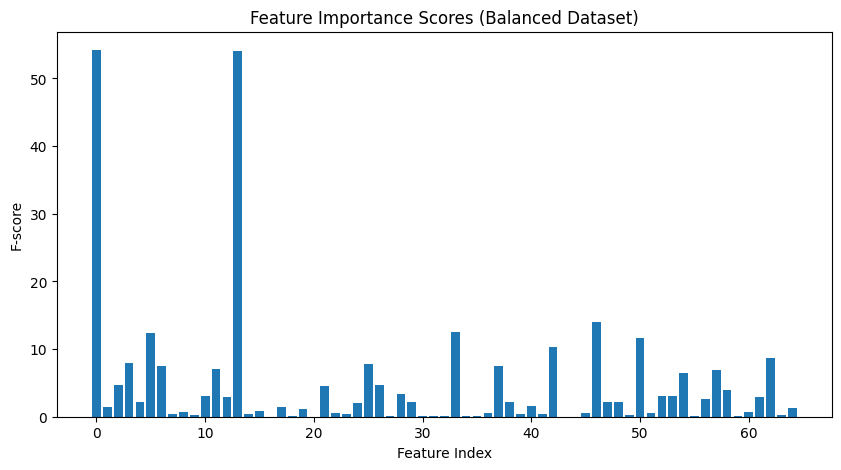

In [ ]:
# Install required libraries
!pip install librosa numpy PyWavelets scikit-learn pandas matplotlib

# Import libraries
import librosa
import numpy as np
import pywt
import os
import glob
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Paths to balanced dataset
copd_folder = "/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/COPD/"
healthy_folder = "/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/Healthy/"

# Get .wav files
copd_files = glob.glob(os.path.join(copd_folder, "*.wav"))
healthy_files = glob.glob(os.path.join(healthy_folder, "*.wav"))

# Verify file counts
print(f"Found {len(copd_files)} COPD files and {len(healthy_files)} Healthy files in balanced dataset.")

# Initialize lists
mfcc_features = []
labels = []

# Function to extract MFCC and apply wavelet transformation
def extract_mfcc_wavelet(file_path, num_mfcc=13, wavelet='db4'):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Standardize sample rate
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Apply wavelet transformation to MFCC
        coeffs = []
        for i in range(mfcc.shape[0]):
            cA, cD = pywt.dwt(mfcc[i], wavelet=wavelet)
            coeffs.extend([np.mean(cA), np.std(cA), np.mean(cD), np.std(cD)])

        return np.concatenate([mfcc_mean, coeffs])
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None

# Process files
for file_path in copd_files:
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(1)  # COPD

for file_path in healthy_files:
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(0)  # Healthy

# Convert to NumPy arrays
mfcc_features = np.array(mfcc_features)
labels = np.array(labels)

# Check for valid data
if mfcc_features.shape[0] == 0:
    raise ValueError("No features extracted. Check audio files or extraction process.")

print("Original MFCC + Wavelet Features Shape:", mfcc_features.shape)
print("Labels Shape:", labels.shape)

# Feature selection
num_features = min(40, mfcc_features.shape[1])  # Select <52 features
selector = SelectKBest(score_func=f_classif, k=num_features)
mfcc_features_selected = selector.fit_transform(mfcc_features, labels)

print("Selected Features Shape:", mfcc_features_selected.shape)

# Analyze selected features
selected_indices = selector.get_support(indices=True)
print("\nSelected Feature Indices:", selected_indices)

# Count MFCC means (indices 0-12)
num_mfcc_means = sum(1 for idx in selected_indices if idx < 13)

# Count wavelet features
num_wavelet = len(selected_indices) - num_mfcc_means

# Break down wavelet features
wavelet_mean_ca = 0
wavelet_std_ca = 0
wavelet_mean_cd = 0
wavelet_std_cd = 0

for idx in selected_indices:
    if idx >= 13:  # Wavelet features start at index 13
        wavelet_idx = idx - 13
        wavelet_type = wavelet_idx % 4
        mfcc_idx = wavelet_idx // 4
        if wavelet_type == 0:  # mean(cA)
            wavelet_mean_ca += 1
            print(f"Index {idx}: mean(cA) for MFCC {mfcc_idx}")
        elif wavelet_type == 1:  # std(cA)
            wavelet_std_ca += 1
            print(f"Index {idx}: std(cA) for MFCC {mfcc_idx}")
        elif wavelet_type == 2:  # mean(cD)
            wavelet_mean_cd += 1
            print(f"Index {idx}: mean(cD) for MFCC {mfcc_idx}")
        elif wavelet_type == 3:  # std(cD)
            wavelet_std_cd += 1
            print(f"Index {idx}: std(cD) for MFCC {mfcc_idx}")

# Print analysis
print("\nFeature Composition Analysis:")
print(f"Total Selected Features: {len(selected_indices)}")
print(f"Number of MFCC Means: {num_mfcc_means}")
print(f"Number of Wavelet Features: {num_wavelet}")
print("Breakdown of Wavelet Features:")
print(f"  mean(cA): {wavelet_mean_ca}")
print(f"  std(cA): {wavelet_std_ca}")
print(f"  mean(cD): {wavelet_mean_cd}")
print(f"  std(cD): {wavelet_std_cd}")

# Create DataFrame for display
feature_columns = [f"Feature_{i}" for i in range(mfcc_features_selected.shape[1])]
df = pd.DataFrame(mfcc_features_selected, columns=feature_columns)
df['Label'] = labels

# Display DataFrame (first 5 rows for brevity)
print("\nMFCC Features (Selected) and Labels (First 5 Rows):")
print(df.head())

# Save DataFrame to CSV for reference
df.to_csv('/content/mfcc_features_selected.csv', index=False)
print("\nSaved features and labels to '/content/mfcc_features_selected.csv'")

# Visualize feature importance
scores = selector.scores_
plt.figure(figsize=(10, 5))
plt.bar(range(len(scores)), scores)
plt.title("Feature Importance Scores (Balanced Dataset)")
plt.xlabel("Feature Index")
plt.ylabel("F-score")
plt.show()

Found 26 COPD files and 26 Healthy files in balanced dataset.
Original MFCC + Wavelet Features Shape: (52, 65)
Labels Shape: (52,)

First Row of Original MFCC Features (First 15 values):
[-371.14914    74.44216    44.511242   25.555645   25.68211    31.60477
   30.003923   22.161667   16.347286   14.90194    14.141905   12.016133
   10.057828 -524.7884     50.894753]
Selected Features Shape: (52, 40)

Selected Feature Indices: [ 0  1  2  3  4  5  6  8 10 11 12 13 15 17 19 21 24 25 26 28 29 33 37 38
 40 42 46 47 48 50 52 53 54 56 57 58 60 61 62 64]
Index 13: mean(cA) for MFCC 0
Index 15: mean(cD) for MFCC 0
Index 17: mean(cA) for MFCC 1
Index 19: mean(cD) for MFCC 1
Index 21: mean(cA) for MFCC 2
Index 24: std(cD) for MFCC 2
Index 25: mean(cA) for MFCC 3
Index 26: std(cA) for MFCC 3
Index 28: std(cD) for MFCC 3
Index 29: mean(cA) for MFCC 4
Index 33: mean(cA) for MFCC 5
Index 37: mean(cA) for MFCC 6
Index 38: std(cA) for MFCC 6
Index 40: std(cD) for MFCC 6
Index 42: std(cA) for MFCC 7
In

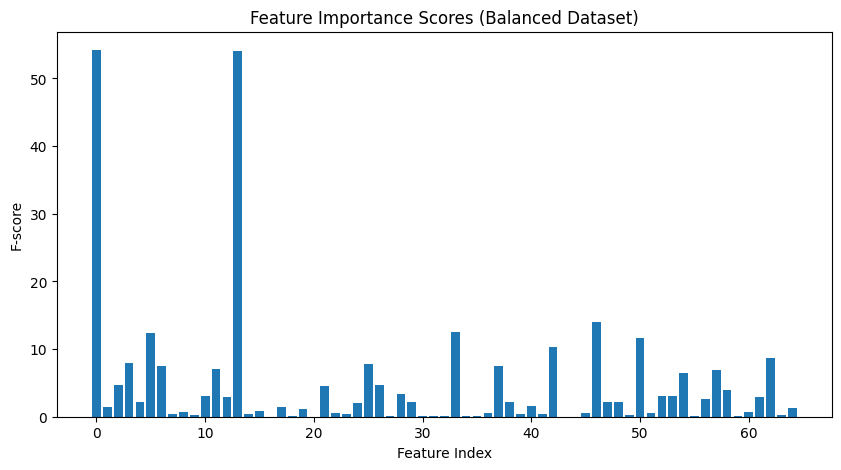

In [ ]:
# Install required libraries
!pip install librosa numpy PyWavelets scikit-learn pandas matplotlib

# Import libraries
import librosa
import numpy as np
import pywt
import os
import glob
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Paths to balanced dataset
copd_folder = "/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/COPD/"
healthy_folder = "/content/drive/MyDrive/KaggleDatasets/Balanced_Respiratory_Sound_Database/Healthy/"

# Get .wav files
copd_files = glob.glob(os.path.join(copd_folder, "*.wav"))
healthy_files = glob.glob(os.path.join(healthy_folder, "*.wav"))

# Verify file counts
print(f"Found {len(copd_files)} COPD files and {len(healthy_files)} Healthy files in balanced dataset.")

# Initialize lists
mfcc_features = []
labels = []

# Function to extract MFCC and apply wavelet transformation
def extract_mfcc_wavelet(file_path, num_mfcc=13, wavelet='db4'):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Standardize sample rate
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Apply wavelet transformation to MFCC
        coeffs = []
        for i in range(mfcc.shape[0]):
            cA, cD = pywt.dwt(mfcc[i], wavelet=wavelet)
            coeffs.extend([np.mean(cA), np.std(cA), np.mean(cD), np.std(cD)])

        return np.concatenate([mfcc_mean, coeffs])
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None

# Process files
for file_path in copd_files:
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(1)  # COPD

for file_path in healthy_files:
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(0)  # Healthy

# Convert to NumPy arrays
mfcc_features = np.array(mfcc_features)
labels = np.array(labels)

# Check for valid data
if mfcc_features.shape[0] == 0:
    raise ValueError("No features extracted. Check audio files or extraction process.")

print("Original MFCC + Wavelet Features Shape:", mfcc_features.shape)
print("Labels Shape:", labels.shape)

# Print first row of mfcc_features to check consistency
print("\nFirst Row of Original MFCC Features (First 15 values):")
print(mfcc_features[0, :15])

# Feature selection
num_features = min(40, mfcc_features.shape[1])  # Select <52 features
selector = SelectKBest(score_func=f_classif, k=num_features)
mfcc_features_selected = selector.fit_transform(mfcc_features, labels)

print("Selected Features Shape:", mfcc_features_selected.shape)

# Analyze selected features
selected_indices = selector.get_support(indices=True)
print("\nSelected Feature Indices:", selected_indices)

# Map indices to feature names
feature_names = []
for idx in selected_indices:
    if idx < 13:
        feature_names.append(f"MFCC_{idx}")
    else:
        wavelet_idx = idx - 13
        wavelet_type = wavelet_idx % 4
        mfcc_idx = wavelet_idx // 4
        if wavelet_type == 0:
            feature_names.append(f"mean(cA)_MFCC_{mfcc_idx}")
        elif wavelet_type == 1:
            feature_names.append(f"std(cA)_MFCC_{mfcc_idx}")
        elif wavelet_type == 2:
            feature_names.append(f"mean(cD)_MFCC_{mfcc_idx}")
        else:
            feature_names.append(f"std(cD)_MFCC_{mfcc_idx}")

# Count MFCC means (indices 0-12)
num_mfcc_means = sum(1 for idx in selected_indices if idx < 13)

# Count wavelet features
num_wavelet = len(selected_indices) - num_mfcc_means

# Break down wavelet features
wavelet_mean_ca = 0
wavelet_std_ca = 0
wavelet_mean_cd = 0
wavelet_std_cd = 0

for idx in selected_indices:
    if idx >= 13:  # Wavelet features start at index 13
        wavelet_idx = idx - 13
        wavelet_type = wavelet_idx % 4
        mfcc_idx = wavelet_idx // 4
        if wavelet_type == 0:  # mean(cA)
            wavelet_mean_ca += 1
            print(f"Index {idx}: mean(cA) for MFCC {mfcc_idx}")
        elif wavelet_type == 1:  # std(cA)
            wavelet_std_ca += 1
            print(f"Index {idx}: std(cA) for MFCC {mfcc_idx}")
        elif wavelet_type == 2:  # mean(cD)
            wavelet_mean_cd += 1
            print(f"Index {idx}: mean(cD) for MFCC {mfcc_idx}")
        elif wavelet_type == 3:  # std(cD)
            wavelet_std_cd += 1
            print(f"Index {idx}: std(cD) for MFCC {mfcc_idx}")

# Print analysis
print("\nFeature Composition Analysis:")
print(f"Total Selected Features: {len(selected_indices)}")
print(f"Number of MFCC Means: {num_mfcc_means}")
print(f"Number of Wavelet Features: {num_wavelet}")
print("Breakdown of Wavelet Features:")
print(f"  mean(cA): {wavelet_mean_ca}")
print(f"  std(cA): {wavelet_std_ca}")
print(f"  mean(cD): {wavelet_mean_cd}")
print(f"  std(cD): {wavelet_std_cd}")

# Create DataFrame with correct column names
df = pd.DataFrame(mfcc_features_selected, columns=feature_names)
df['Label'] = labels

# Display DataFrame (first 5 rows for brevity)
print("\nMFCC Features (Selected) and Labels (First 5 Rows):")
print(df.head())

# Save DataFrame to CSV for reference
df.to_csv('/content/mfcc_features_selected.csv', index=False)
print("\nSaved features and labels to '/content/mfcc_features_selected.csv'")

# Visualize feature importance
scores = selector.scores_
plt.figure(figsize=(10, 5))
plt.bar(range(len(scores)), scores)
plt.title("Feature Importance Scores (Balanced Dataset)")
plt.xlabel("Feature Index")
plt.ylabel("F-score")
plt.show()


📂 Fold 1
SVM Fold 1 - Accuracy: 0.8182, Precision: 0.8333, Recall: 0.8333, F1-Score: 0.8333
Random Forest Fold 1 - Accuracy: 0.9091, Precision: 0.8571, Recall: 1.0000, F1-Score: 0.9231
ANN Fold 1 - Accuracy: 0.9091, Precision: 0.8571, Recall: 1.0000, F1-Score: 0.9231


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
CNN Fold 1 - Accuracy: 0.9091, Precision: 0.8571, Recall: 1.0000, F1-Score: 0.9231

📂 Fold 2
SVM Fold 2 - Accuracy: 0.8182, Precision: 0.8000, Recall: 0.8000, F1-Score: 0.8000
Random Forest Fold 2 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
ANN Fold 2 - Accuracy: 0.8182, Precision: 0.8000, Recall: 0.8000, F1-Score: 0.8000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
CNN Fold 2 - Accuracy: 0.8182, Precision: 1.0000, Recall: 0.6000, F1-Score: 0.7500

📂 Fold 3
SVM Fold 3 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
Random Forest Fold 3 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
ANN Fold 3 - Accuracy: 0.9000, Precision: 0.8333, Recall: 1.0000, F1-Score: 0.9091


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
CNN Fold 3 - Accuracy: 0.8000, Precision: 0.7143, Recall: 1.0000, F1-Score: 0.8333

📂 Fold 4
SVM Fold 4 - Accuracy: 0.7000, Precision: 1.0000, Recall: 0.4000, F1-Score: 0.5714
Random Forest Fold 4 - Accuracy: 0.9000, Precision: 1.0000, Recall: 0.8000, F1-Score: 0.8889
ANN Fold 4 - Accuracy: 0.8000, Precision: 1.0000, Recall: 0.6000, F1-Score: 0.7500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
CNN Fold 4 - Accuracy: 0.7000, Precision: 1.0000, Recall: 0.4000, F1-Score: 0.5714

📂 Fold 5
SVM Fold 5 - Accuracy: 0.7000, Precision: 1.0000, Recall: 0.4000, F1-Score: 0.5714
Random Forest Fold 5 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
ANN Fold 5 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
CNN Fold 5 - Accuracy: 0.7000, Precision: 0.6667, Recall: 0.8000, F1-Score: 0.7273

Balanced Dataset Results (Average over 5 folds):
           Model  Accuracy  Precision    Recall  F1-Score
0            SVM  0.807273   0.926667  0.686667  0.755238
1  Random Forest  0.961818   0.971429  0.960000  0.962393
2            ANN  0.885455   0.898095  0.880000  0.876434
3            CNN  0.785455   0.847619  0.760000  0.761022


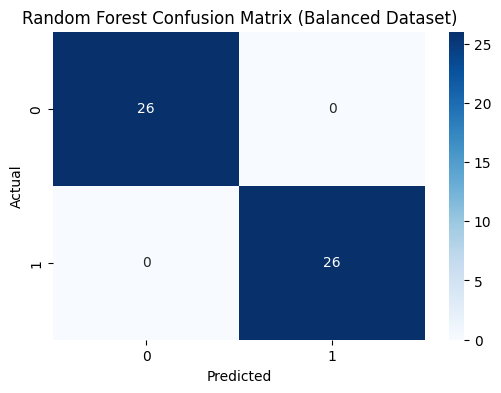

In [ ]:
# Install required libraries for Step 3
!pip install scikit-learn tensorflow pandas seaborn matplotlib

# Import libraries
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Use mfcc_features_selected and labels from Step 2
X = mfcc_features_selected  # Shape: (52, 40)
y = labels  # Shape: (52,)

# Initialize models
svm = SVC(kernel='rbf', probability=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
ann = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

def create_cnn(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize results dictionary
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n📂 Fold {fold}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train and evaluate SVM
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    svm_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred_svm),
        'Precision': precision_score(y_test, y_pred_svm, zero_division=0),
        'Recall': recall_score(y_test, y_pred_svm, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred_svm, zero_division=0)
    }
    print(f"SVM Fold {fold} - Accuracy: {svm_metrics['Accuracy']:.4f}, "
          f"Precision: {svm_metrics['Precision']:.4f}, "
          f"Recall: {svm_metrics['Recall']:.4f}, "
          f"F1-Score: {svm_metrics['F1-Score']:.4f}")

    # Train and evaluate Random Forest
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    rf_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Precision': precision_score(y_test, y_pred_rf, zero_division=0),
        'Recall': recall_score(y_test, y_pred_rf, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred_rf, zero_division=0)
    }
    print(f"Random Forest Fold {fold} - Accuracy: {rf_metrics['Accuracy']:.4f}, "
          f"Precision: {rf_metrics['Precision']:.4f}, "
          f"Recall: {rf_metrics['Recall']:.4f}, "
          f"F1-Score: {rf_metrics['F1-Score']:.4f}")

    # Train and evaluate ANN
    ann.fit(X_train, y_train)
    y_pred_ann = ann.predict(X_test)
    ann_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred_ann),
        'Precision': precision_score(y_test, y_pred_ann, zero_division=0),
        'Recall': recall_score(y_test, y_pred_ann, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred_ann, zero_division=0)
    }
    print(f"ANN Fold {fold} - Accuracy: {ann_metrics['Accuracy']:.4f}, "
          f"Precision: {ann_metrics['Precision']:.4f}, "
          f"Recall: {ann_metrics['Recall']:.4f}, "
          f"F1-Score: {ann_metrics['F1-Score']:.4f}")

    # Train and evaluate CNN
    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    cnn = create_cnn((X_train.shape[1], 1))
    cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=16, verbose=0)
    y_pred_cnn = (cnn.predict(X_test_cnn) > 0.5).astype(int).flatten()
    cnn_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred_cnn),
        'Precision': precision_score(y_test, y_pred_cnn, zero_division=0),
        'Recall': recall_score(y_test, y_pred_cnn, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred_cnn, zero_division=0)
    }
    print(f"CNN Fold {fold} - Accuracy: {cnn_metrics['Accuracy']:.4f}, "
          f"Precision: {cnn_metrics['Precision']:.4f}, "
          f"Recall: {cnn_metrics['Recall']:.4f}, "
          f"F1-Score: {cnn_metrics['F1-Score']:.4f}")

    # Store fold results (accumulate for averaging)
    if fold == 1:
        results['Model'].extend(['SVM', 'Random Forest', 'ANN', 'CNN'])
        results['Accuracy'].extend([svm_metrics['Accuracy'], rf_metrics['Accuracy'], ann_metrics['Accuracy'], cnn_metrics['Accuracy']])
        results['Precision'].extend([svm_metrics['Precision'], rf_metrics['Precision'], ann_metrics['Precision'], cnn_metrics['Precision']])
        results['Recall'].extend([svm_metrics['Recall'], rf_metrics['Recall'], ann_metrics['Recall'], cnn_metrics['Recall']])
        results['F1-Score'].extend([svm_metrics['F1-Score'], rf_metrics['F1-Score'], ann_metrics['F1-Score'], cnn_metrics['F1-Score']])
    else:
        results['Accuracy'][0] += svm_metrics['Accuracy']
        results['Accuracy'][1] += rf_metrics['Accuracy']
        results['Accuracy'][2] += ann_metrics['Accuracy']
        results['Accuracy'][3] += cnn_metrics['Accuracy']
        results['Precision'][0] += svm_metrics['Precision']
        results['Precision'][1] += rf_metrics['Precision']
        results['Precision'][2] += ann_metrics['Precision']
        results['Precision'][3] += cnn_metrics['Precision']
        results['Recall'][0] += svm_metrics['Recall']
        results['Recall'][1] += rf_metrics['Recall']
        results['Recall'][2] += ann_metrics['Recall']
        results['Recall'][3] += cnn_metrics['Recall']
        results['F1-Score'][0] += svm_metrics['F1-Score']
        results['F1-Score'][1] += rf_metrics['F1-Score']
        results['F1-Score'][2] += ann_metrics['F1-Score']
        results['F1-Score'][3] += cnn_metrics['F1-Score']

# Average metrics across folds
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    results[metric] = [x/5 for x in results[metric]]

# Create and display table
results_df = pd.DataFrame(results)
print("\nBalanced Dataset Results (Average over 5 folds):")
print(results_df)

# Plot confusion matrix for Random Forest (trained on full balanced dataset)
rf.fit(X, y)
y_pred_rf_full = rf.predict(X)
cm = confusion_matrix(y, y_pred_rf_full)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix (Balanced Dataset)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


📂 Fold 1
Training indices: [ 0  1  3  4  5  6  8 11 12 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 36 37 38 39 40 43 44 45 46 47 48 49 50 51]
Testing indices: [ 2  7  9 10 13 14 33 34 35 41 42]
Training labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Testing labels: [1 1 1 1 1 1 0 0 0 0 0]

SVM Fold 1 Accuracy: 0.8182
Confusion Matrix for Fold:
[[4 1]
 [1 5]]

Random Forest Fold 1 Accuracy: 0.9091
Confusion Matrix for Fold:
[[4 1]
 [0 6]]

ANN Fold 1 Accuracy: 0.9091
Confusion Matrix for Fold:
[[4 1]
 [0 6]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

CNN Fold 1 Accuracy: 0.8182
Confusion Matrix for Fold:
[[3 2]
 [0 6]]

📂 Fold 2
Training indices: [ 1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 23 24 26 29 30
 32 33 34 35 36 38 40 41 42 43 44 45 46 48 49 50 51]
Testing indices: [ 0  5 21 22 25 27 28 31 37 39 47]
Training labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
Testing labels: [1 1 1 1 1 0 0 0 0 0 0]

SVM Fold 2 Accuracy: 0.8182
Confusion Matrix for Fold:
[[5 1]
 [1 4]]

Random Forest Fold 2 Accuracy: 1.0000
Confusion Matrix for Fold:
[[6 0]
 [0 5]]

ANN Fold 2 Accuracy: 0.8182
Confusion Matrix for Fold:
[[5 1]
 [1 4]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

CNN Fold 2 Accuracy: 0.5455
Confusion Matrix for Fold:
[[3 3]
 [2 3]]

📂 Fold 3
Training indices: [ 0  1  2  3  5  7  8  9 10 13 14 15 16 17 18 19 20 21 22 24 25 26 27 28
 30 31 32 33 34 35 37 38 39 40 41 42 43 44 47 48 49 50]
Testing indices: [ 4  6 11 12 23 29 36 45 46 51]
Training labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
Testing labels: [1 1 1 1 1 0 0 0 0 0]

SVM Fold 3 Accuracy: 1.0000
Confusion Matrix for Fold:
[[5 0]
 [0 5]]

Random Forest Fold 3 Accuracy: 1.0000
Confusion Matrix for Fold:
[[5 0]
 [0 5]]

ANN Fold 3 Accuracy: 0.9000
Confusion Matrix for Fold:
[[4 1]
 [0 5]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

CNN Fold 3 Accuracy: 0.8000
Confusion Matrix for Fold:
[[5 0]
 [2 3]]

📂 Fold 4
Training indices: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 19 21 22 23 25 27 28 29
 30 31 33 34 35 36 37 39 40 41 42 43 45 46 47 49 50 51]
Testing indices: [ 1 16 18 20 24 26 32 38 44 48]
Training labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
Testing labels: [1 1 1 1 1 0 0 0 0 0]

SVM Fold 4 Accuracy: 0.7000
Confusion Matrix for Fold:
[[5 0]
 [3 2]]

Random Forest Fold 4 Accuracy: 0.9000
Confusion Matrix for Fold:
[[5 0]
 [1 4]]

ANN Fold 4 Accuracy: 0.8000
Confusion Matrix for Fold:
[[5 0]
 [2 3]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

CNN Fold 4 Accuracy: 0.8000
Confusion Matrix for Fold:
[[4 1]
 [1 4]]

📂 Fold 5
Training indices: [ 0  1  2  4  5  6  7  9 10 11 12 13 14 16 18 20 21 22 23 24 25 26 27 28
 29 31 32 33 34 35 36 37 38 39 41 42 44 45 46 47 48 51]
Testing indices: [ 3  8 15 17 19 30 40 43 49 50]
Training labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
Testing labels: [1 1 1 1 1 0 0 0 0 0]

SVM Fold 5 Accuracy: 0.7000
Confusion Matrix for Fold:
[[5 0]
 [3 2]]

Random Forest Fold 5 Accuracy: 1.0000
Confusion Matrix for Fold:
[[5 0]
 [0 5]]

ANN Fold 5 Accuracy: 1.0000
Confusion Matrix for Fold:
[[5 0]
 [0 5]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

CNN Fold 5 Accuracy: 0.6000
Confusion Matrix for Fold:
[[5 0]
 [4 1]]

SVM Cross-validation Mean Accuracy: 0.8073
Standard Deviation: 0.1099

Random Forest Cross-validation Mean Accuracy: 0.9618
Standard Deviation: 0.0469

ANN Cross-validation Mean Accuracy: 0.8855
Standard Deviation: 0.0717

CNN Cross-validation Mean Accuracy: 0.7127
Standard Deviation: 0.1158

Balanced Dataset Results (Average over 5 folds):
           Model  Accuracy  Precision    Recall  F1-Score
0            SVM  0.807273   0.926667  0.686667  0.755238
1  Random Forest  0.961818   0.971429  0.960000  0.962393
2            ANN  0.885455   0.898095  0.880000  0.876434
3            CNN  0.712727   0.810000  0.640000  0.657186

=== SVM Overall Metrics (Trained on Full Balanced Dataset) ===
Overall Confusion Matrix:
[[26  0]
 [ 8 18]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.87        26
           1    

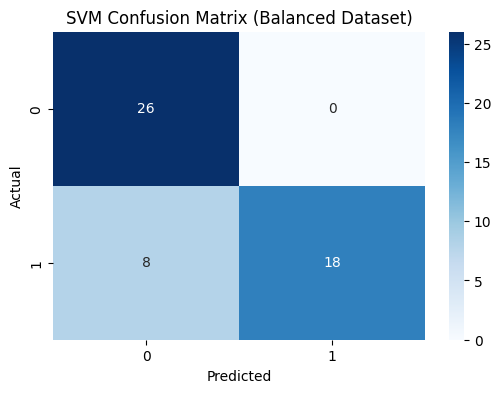


=== Random Forest Overall Metrics (Trained on Full Balanced Dataset) ===
Overall Confusion Matrix:
[[26  0]
 [ 0 26]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        26

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



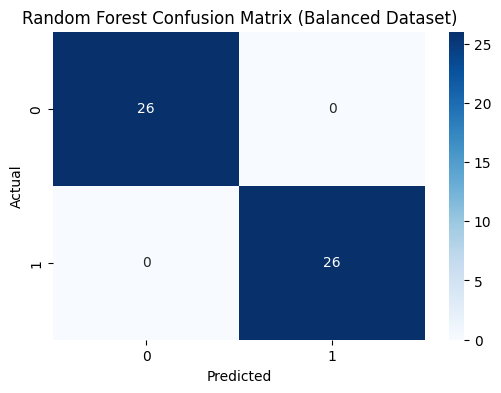


=== ANN Overall Metrics (Trained on Full Balanced Dataset) ===
Overall Confusion Matrix:
[[26  0]
 [ 0 26]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        26

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


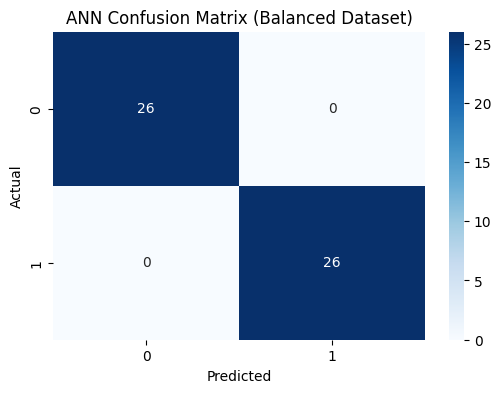

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



=== CNN Overall Metrics (Trained on Full Balanced Dataset) ===
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Overall Confusion Matrix:
[[26  0]
 [12 14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        26
           1       1.00      0.54      0.70        26

    accuracy                           0.77        52
   macro avg       0.84      0.77      0.76        52
weighted avg       0.84      0.77      0.76        52



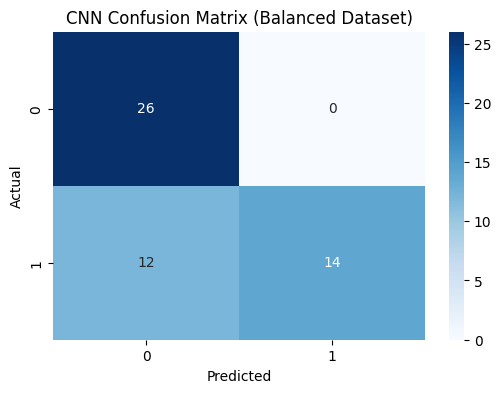

In [ ]:
# Install required libraries for Step 3
!pip install scikit-learn tensorflow pandas seaborn matplotlib

# Import libraries
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Use mfcc_features_selected and labels from Step 2
X = mfcc_features_selected  # Shape: (52, 40)
y = labels  # Shape: (52,)

# Initialize models
svm = SVC(kernel='rbf', probability=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
ann = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

def create_cnn(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize dictionaries to store fold accuracies for each model
fold_accuracies = {
    'SVM': [],
    'Random Forest': [],
    'ANN': [],
    'CNN': []
}

# Initialize results dictionary for average metrics table
results = {
    'Model': ['SVM', 'Random Forest', 'ANN', 'CNN'],
    'Accuracy': [0.0, 0.0, 0.0, 0.0],
    'Precision': [0.0, 0.0, 0.0, 0.0],
    'Recall': [0.0, 0.0, 0.0, 0.0],
    'F1-Score': [0.0, 0.0, 0.0, 0.0]
}

# 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n📂 Fold {fold}")
    print(f"Training indices: {train_idx}")
    print(f"Testing indices: {test_idx}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    print(f"Training labels: {y_train}")
    print(f"Testing labels: {y_test}")

    # SVM
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    svm_accuracy = accuracy_score(y_test, y_pred_svm)
    fold_accuracies['SVM'].append(svm_accuracy)
    svm_cm = confusion_matrix(y_test, y_pred_svm)
    print(f"\nSVM Fold {fold} Accuracy: {svm_accuracy:.4f}")
    print("Confusion Matrix for Fold:")
    print(svm_cm)
    # Update metrics
    results['Accuracy'][0] += svm_accuracy
    results['Precision'][0] += precision_score(y_test, y_pred_svm, zero_division=0)
    results['Recall'][0] += recall_score(y_test, y_pred_svm, zero_division=0)
    results['F1-Score'][0] += f1_score(y_test, y_pred_svm, zero_division=0)

    # Random Forest
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    rf_accuracy = accuracy_score(y_test, y_pred_rf)
    fold_accuracies['Random Forest'].append(rf_accuracy)
    rf_cm = confusion_matrix(y_test, y_pred_rf)
    print(f"\nRandom Forest Fold {fold} Accuracy: {rf_accuracy:.4f}")
    print("Confusion Matrix for Fold:")
    print(rf_cm)
    # Update metrics
    results['Accuracy'][1] += rf_accuracy
    results['Precision'][1] += precision_score(y_test, y_pred_rf, zero_division=0)
    results['Recall'][1] += recall_score(y_test, y_pred_rf, zero_division=0)
    results['F1-Score'][1] += f1_score(y_test, y_pred_rf, zero_division=0)

    # ANN
    ann.fit(X_train, y_train)
    y_pred_ann = ann.predict(X_test)
    ann_accuracy = accuracy_score(y_test, y_pred_ann)
    fold_accuracies['ANN'].append(ann_accuracy)
    ann_cm = confusion_matrix(y_test, y_pred_ann)
    print(f"\nANN Fold {fold} Accuracy: {ann_accuracy:.4f}")
    print("Confusion Matrix for Fold:")
    print(ann_cm)
    # Update metrics
    results['Accuracy'][2] += ann_accuracy
    results['Precision'][2] += precision_score(y_test, y_pred_ann, zero_division=0)
    results['Recall'][2] += recall_score(y_test, y_pred_ann, zero_division=0)
    results['F1-Score'][2] += f1_score(y_test, y_pred_ann, zero_division=0)

    # CNN
    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    cnn = create_cnn((X_train.shape[1], 1))
    cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=16, verbose=0)
    y_pred_cnn = (cnn.predict(X_test_cnn) > 0.5).astype(int).flatten()
    cnn_accuracy = accuracy_score(y_test, y_pred_cnn)
    fold_accuracies['CNN'].append(cnn_accuracy)
    cnn_cm = confusion_matrix(y_test, y_pred_cnn)
    print(f"\nCNN Fold {fold} Accuracy: {cnn_accuracy:.4f}")
    print("Confusion Matrix for Fold:")
    print(cnn_cm)
    # Update metrics
    results['Accuracy'][3] += cnn_accuracy
    results['Precision'][3] += precision_score(y_test, y_pred_cnn, zero_division=0)
    results['Recall'][3] += recall_score(y_test, y_pred_cnn, zero_division=0)
    results['F1-Score'][3] += f1_score(y_test, y_pred_cnn, zero_division=0)

# Compute mean and standard deviation of accuracies for each model
for model_name in fold_accuracies:
    mean_accuracy = np.mean(fold_accuracies[model_name])
    std_accuracy = np.std(fold_accuracies[model_name])
    print(f"\n{model_name} Cross-validation Mean Accuracy: {mean_accuracy:.4f}")
    print(f"Standard Deviation: {std_accuracy:.4f}")

# Average metrics across folds for the results table
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    results[metric] = [x/5 for x in results[metric]]

# Create and display table
results_df = pd.DataFrame(results)
print("\nBalanced Dataset Results (Average over 5 folds):")
print(results_df)

# Train each model on the full balanced dataset and display overall metrics
models = {
    'SVM': svm,
    'Random Forest': rf,
    'ANN': ann,
    'CNN': None  # CNN will be created separately
}

for model_name in models:
    print(f"\n=== {model_name} Overall Metrics (Trained on Full Balanced Dataset) ===")
    if model_name == 'CNN':
        X_cnn = X.reshape(X.shape[0], X.shape[1], 1)
        model = create_cnn((X.shape[1], 1))
        model.fit(X_cnn, y, epochs=10, batch_size=16, verbose=0)
        y_pred = (model.predict(X_cnn) > 0.5).astype(int).flatten()
    else:
        model = models[model_name]
        model.fit(X, y)
        y_pred = model.predict(X)

    # Overall confusion matrix
    cm = confusion_matrix(y, y_pred)
    print("Overall Confusion Matrix:")
    print(cm)

    # Classification report
    print("Classification Report:")
    print(classification_report(y, y_pred, zero_division=0))

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix (Balanced Dataset)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/"

Respiratory_Sound_Database


In [ ]:
!find "/content/drive/MyDrive/" -type d -name "audio_and_txt_files"

/content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files
/content/drive/MyDrive/KaggleDatasets/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files


In [ ]:
# Import libraries
import os
import glob
import pandas as pd
import random

# Set random seed for reproducibility
random.seed(42)

# Paths to full dataset
audio_folder = "/content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
diagnosis_file = "/content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv"

# Check if paths exist
if not os.path.exists(audio_folder):
    raise FileNotFoundError(f"Audio folder not found at {audio_folder}")
if not os.path.exists(diagnosis_file):
    raise FileNotFoundError(f"Diagnosis file not found at {diagnosis_file}")

# Load diagnosis file
diagnosis_df = pd.read_csv(diagnosis_file, header=None, names=['Patient_ID', 'Diagnosis'])

# Filter for COPD and Healthy patients
diagnosis_df = diagnosis_df[diagnosis_df['Diagnosis'].isin(['COPD', 'Healthy'])]
print("Diagnosis DataFrame:")
print(diagnosis_df)

# Get .wav files
audio_files = glob.glob(os.path.join(audio_folder, "*.wav"))
print(f"Found {len(audio_files)} audio files in {audio_folder}")

# Map audio files to labels
file_label_pairs = []
for audio_file in audio_files:
    filename = os.path.basename(audio_file)
    patient_id = int(filename.split('_')[0])
    diagnosis_row = diagnosis_df[diagnosis_df['Patient_ID'] == patient_id]
    if not diagnosis_row.empty:
        diagnosis = diagnosis_row['Diagnosis'].iloc[0]
        label = 1 if diagnosis == 'COPD' else 0  # COPD: 1, Healthy: 0
        file_label_pairs.append((audio_file, label))

# Separate into COPD and Healthy
copd_files = [pair[0] for pair in file_label_pairs if pair[1] == 1]
healthy_files = [pair[0] for pair in file_label_pairs if pair[1] == 0]

print(f"Before balancing - Found {len(copd_files)} COPD files and {len(healthy_files)} Healthy files in full dataset.")

# Balance the dataset
num_healthy = len(healthy_files)  # 64
copd_files_balanced = random.sample(copd_files, num_healthy)  # Randomly select 64 COPD files
balanced_files = [(f, 1) for f in copd_files_balanced] + [(f, 0) for f in healthy_files]

# Shuffle the balanced dataset
random.shuffle(balanced_files)

# Separate into files and labels
balanced_audio_files = [pair[0] for pair in balanced_files]
balanced_labels = [pair[1] for pair in balanced_files]

print(f"After balancing - Found {len(balanced_audio_files)} files: {sum(balanced_labels)} COPD, {len(balanced_labels) - sum(balanced_labels)} Healthy")
print("Sample balanced audio files:", balanced_audio_files[:3])
print("Sample balanced labels:", balanced_labels[:3])

Diagnosis DataFrame:
     Patient_ID Diagnosis
1           102   Healthy
3           104      COPD
5           106      COPD
6           107      COPD
8           109      COPD
..          ...       ...
120         221      COPD
121         222      COPD
122         223      COPD
123         224   Healthy
124         225   Healthy

[90 rows x 2 columns]
Found 920 audio files in /content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/
Before balancing - Found 793 COPD files and 35 Healthy files in full dataset.
After balancing - Found 70 files: 35 COPD, 35 Healthy
Sample balanced audio files: ['/content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/187_1b1_Ll_sc_Meditron.wav', '/content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/184_1b1_Ar_sc_Meditron.wav', '/content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Dat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 11.1 MB/s eta 0:00:00
Original MFCC + Wavelet Features Shape: (70, 65)
Labels Shape: (70,)
Selected Features Shape: (70, 40)
Selected Feature Indices: [ 0  1  3  4  5  6  9 10 13 14 16 17 18 20 22 24 25 26 28 29 30 31 32 33
 34 35 36 37 38 42 44 46 48 49 50 52 53 54 58 62]
Number of MFCC Means: 8
Number of Wavelet Features: 32

MFCC Features (Selected) and Labels (First 5 Rows):
    Feature_0   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0 -442.286987   67.054993  36.847416  31.044718  26.446583  19.489687   
1 -572.460022   60.277344  44.711128  37.569675  31.198050  25.472857   
2 -375.942352  110.521561  48.169323  29.172768  26.494730  12.425595   
3 -275.031372  108.985306  46.110870  29.111771  25.477528  15.218781   
4 -475.059174   85.472641  43.515434  30.346617  24.590168  21.677588   

   Feature_6  Feature_7   Feature_8  Feature_9  ...  Feature_31  Feature_32  \
0  13.087163  12.805669 -625.169556  42.85618

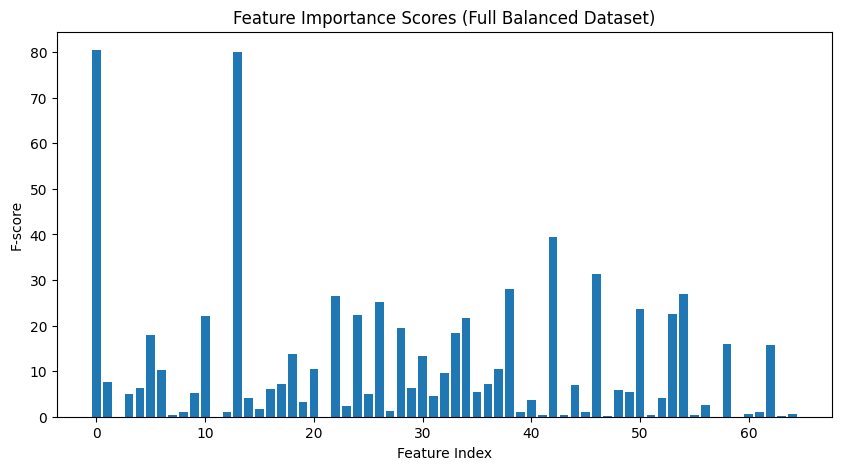

In [ ]:
# Install required libraries
!pip install librosa numpy PyWavelets scikit-learn pandas matplotlib

# Import libraries
import librosa
import numpy as np
import pywt
import os
import glob
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import matplotlib.pyplot as plt

# Assume balanced_audio_files and balanced_labels are defined from Step 1
# For example:
# balanced_audio_files = ['/path/to/file1.wav', '/path/to/file2.wav', ...]
# balanced_labels = [1, 0, 1, ...]

# Initialize lists
mfcc_features = []
labels = []

# Function to extract MFCC and apply wavelet transformation
def extract_mfcc_wavelet(file_path, num_mfcc=13, wavelet='db4'):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Standardize sample rate
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Apply wavelet transformation to MFCC
        coeffs = []
        for i in range(mfcc.shape[0]):
            cA, cD = pywt.dwt(mfcc[i], wavelet=wavelet)
            coeffs.extend([np.mean(cA), np.std(cA), np.mean(cD), np.std(cD)])

        return np.concatenate([mfcc_mean, coeffs])
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None

# Process files
for file_path, label in zip(balanced_audio_files, balanced_labels):
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(label)

# Convert to NumPy arrays
mfcc_features = np.array(mfcc_features)
labels = np.array(labels)

# Check for valid data
if mfcc_features.shape[0] == 0:
    raise ValueError("No features extracted. Check audio files or extraction process.")

print("Original MFCC + Wavelet Features Shape:", mfcc_features.shape)
print("Labels Shape:", labels.shape)

# Feature selection
num_features = min(40, mfcc_features.shape[1])  # Select <70 features
selector = SelectKBest(score_func=f_classif, k=num_features)
mfcc_features_selected = selector.fit_transform(mfcc_features, labels)

print("Selected Features Shape:", mfcc_features_selected.shape)

# Analyze selected features
selected_indices = selector.get_support(indices=True)
print("Selected Feature Indices:", selected_indices)

# Count MFCC means (indices 0-12)
num_mfcc_means = sum(1 for idx in selected_indices if idx < 13)

# Count wavelet features
num_wavelet = len(selected_indices) - num_mfcc_means

print(f"Number of MFCC Means: {num_mfcc_means}")
print(f"Number of Wavelet Features: {num_wavelet}")

# Create DataFrame for display
feature_columns = [f"Feature_{i}" for i in range(mfcc_features_selected.shape[1])]
df = pd.DataFrame(mfcc_features_selected, columns=feature_columns)
df['Label'] = labels

# Display DataFrame (first 5 rows for brevity)
print("\nMFCC Features (Selected) and Labels (First 5 Rows):")
print(df.head())

# Save DataFrame to CSV for reference
df.to_csv('/content/mfcc_features_selected_full_balanced.csv', index=False)
print("\nSaved features and labels to '/content/mfcc_features_selected_full_balanced.csv'")

# Visualize feature importance
scores = selector.scores_
plt.figure(figsize=(10, 5))
plt.bar(range(len(scores)), scores)
plt.title("Feature Importance Scores (Full Balanced Dataset)")
plt.xlabel("Feature Index")
plt.ylabel("F-score")
plt.savefig('/content/feature_importance_full_balanced.png')
print("\nSaved feature importance plot to '/content/feature_importance_full_balanced.png'")

Original MFCC + Wavelet Features Shape: (70, 65)
Labels Shape: (70,)
Selected Features Shape: (70, 50)
Selected Feature Indices: [ 0  1  3  4  5  6  9 10 12 13 14 15 16 17 18 19 20 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 42 44 45 46 48 49 50 52 53 54 56 58
 61 62]
Number of MFCC Means: 9
Number of Wavelet Features: 41

MFCC Features (Selected) and Labels (First 5 Rows):
    Feature_0   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0 -442.286987   67.054993  36.847416  31.044718  26.446583  19.489687   
1 -572.460022   60.277344  44.711128  37.569675  31.198050  25.472857   
2 -375.942352  110.521561  48.169323  29.172768  26.494730  12.425595   
3 -275.031372  108.985306  46.110870  29.111771  25.477528  15.218781   
4 -475.059174   85.472641  43.515434  30.346617  24.590168  21.677588   

   Feature_6  Feature_7  Feature_8   Feature_9  ...  Feature_41  Feature_42  \
0  13.087163  12.805669   7.506248 -625.169556  ...   18.484838    8.014243   
1  15.022885

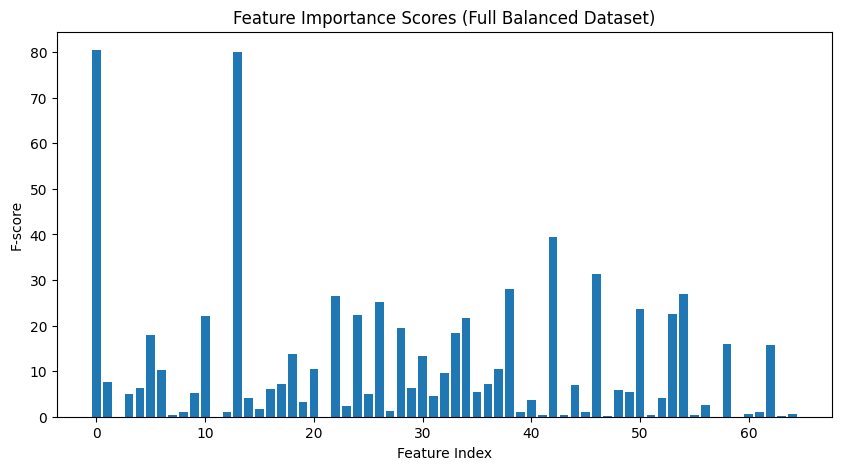

In [ ]:
# Install required libraries
!pip install librosa numpy PyWavelets scikit-learn pandas matplotlib

# Import libraries
import librosa
import numpy as np
import pywt
import os
import glob
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import matplotlib.pyplot as plt

# Assume balanced_audio_files and balanced_labels are defined from Step 1
# For example:
# balanced_audio_files = ['/path/to/file1.wav', '/path/to/file2.wav', ...]
# balanced_labels = [1, 0, 1, ...]

# Initialize lists
mfcc_features = []
labels = []

# Function to extract MFCC and apply wavelet transformation
def extract_mfcc_wavelet(file_path, num_mfcc=13, wavelet='db4'):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Standardize sample rate
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Apply wavelet transformation to MFCC
        coeffs = []
        for i in range(mfcc.shape[0]):
            cA, cD = pywt.dwt(mfcc[i], wavelet=wavelet)
            coeffs.extend([np.mean(cA), np.std(cA), np.mean(cD), np.std(cD)])

        return np.concatenate([mfcc_mean, coeffs])
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None

# Process files
for file_path, label in zip(balanced_audio_files, balanced_labels):
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(label)

# Convert to NumPy arrays
mfcc_features = np.array(mfcc_features)
labels = np.array(labels)

# Check for valid data
if mfcc_features.shape[0] == 0:
    raise ValueError("No features extracted. Check audio files or extraction process.")

print("Original MFCC + Wavelet Features Shape:", mfcc_features.shape)
print("Labels Shape:", labels.shape)

# Feature selection
num_features = min(50, mfcc_features.shape[1])  # Select up to 50 features
selector = SelectKBest(score_func=f_classif, k=num_features)
mfcc_features_selected = selector.fit_transform(mfcc_features, labels)

print("Selected Features Shape:", mfcc_features_selected.shape)

# Analyze selected features
selected_indices = selector.get_support(indices=True)
print("Selected Feature Indices:", selected_indices)

# Count MFCC means (indices 0-12)
num_mfcc_means = sum(1 for idx in selected_indices if idx < 13)

# Count wavelet features
num_wavelet = len(selected_indices) - num_mfcc_means

print(f"Number of MFCC Means: {num_mfcc_means}")
print(f"Number of Wavelet Features: {num_wavelet}")

# Create DataFrame for display
feature_columns = [f"Feature_{i}" for i in range(mfcc_features_selected.shape[1])]
df = pd.DataFrame(mfcc_features_selected, columns=feature_columns)
df['Label'] = labels

# Display DataFrame (first 5 rows for brevity)
print("\nMFCC Features (Selected) and Labels (First 5 Rows):")
print(df.head())

# Save DataFrame to CSV for reference
df.to_csv('/content/mfcc_features_selected_full_balanced.csv', index=False)
print("\nSaved features and labels to '/content/mfcc_features_selected_full_balanced.csv'")

# Visualize feature importance
scores = selector.scores_
plt.figure(figsize=(10, 5))
plt.bar(range(len(scores)), scores)
plt.title("Feature Importance Scores (Full Balanced Dataset)")
plt.xlabel("Feature Index")
plt.ylabel("F-score")
plt.savefig('/content/feature_importance_full_balanced.png')
print("\nSaved feature importance plot to '/content/feature_importance_full_balanced.png'")

Found 920 audio files in /content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/
Found 793 COPD files and 127 non-COPD files in full dataset.
Selected subset: 126 files (64 COPD, 62 non-COPD)
Original MFCC + Wavelet Features Shape: (126, 65)
Labels Shape: (126,)
Selected Features Shape: (126, 50)
Selected Feature Indices: [ 0  1  2  4  5  6  7  8  9 10 12 13 15 16 17 18 19 20 21 22 23 24 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 49 50 53 54 58 61
 62 64]
Number of MFCC Means: 11
Number of Wavelet Features: 39

MFCC Features (Selected) and Labels (First 5 Rows):
    Feature_0   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0 -273.624969  171.313766  47.340332  18.039135   5.381822  -1.272817   
1 -478.179291  100.735161  46.928131  21.706299  25.184097  18.145760   
2 -421.932434   67.155571  57.170795  30.402742  19.548214  12.575086   
3 -275.031372  108.985306  49.949589  29.111771  25.477528  15.2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step

CNN Fold 1 Accuracy: 0.8077
Confusion Matrix for Fold:
[[10  3]
 [ 2 11]]

📂 Fold 2
Training indices: [  0   1   2   3   5   6   7   8   9  11  12  14  15  16  17  18  19  20
  22  23  24  26  27  28  29  30  31  32  34  35  36  37  38  39  40  41
  43  44  45  46  47  48  49  50  51  52  53  55  56  57  58  59  61  62
  63  64  67  68  69  74  75  76  77  78  80  81  82  83  84  85  86  87
  88  89  90  92  93  94  96  97  98  99 100 101 102 103 105 106 107 108
 109 111 113 114 117 118 121 122 123 124 125]
Testing indices: [  4  10  13  21  25  33  42  54  60  65  66  70  71  72  73  79  91  95
 104 110 112 115 116 119 120]
Training labels: [1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1
 1 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1
 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 0]
Testing labels: [0 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1]

SVM Fold 2 Accuracy: 0.9200
Confusi

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

CNN Fold 2 Accuracy: 0.8800
Confusion Matrix for Fold:
[[11  1]
 [ 2 11]]

📂 Fold 3
Training indices: [  0   1   2   3   4   5   6   7   8  10  11  13  14  15  16  17  18  19
  21  23  24  25  26  27  28  29  30  31  32  33  34  37  38  39  40  41
  42  43  44  45  47  48  49  51  52  53  54  56  57  58  60  62  63  64
  65  66  69  70  71  72  73  74  75  76  77  79  80  82  85  86  87  88
  89  90  91  93  95  97  98  99 100 101 102 104 105 106 107 108 109 110
 111 112 113 115 116 117 118 119 120 122 125]
Testing indices: [  9  12  20  22  35  36  46  50  55  59  61  67  68  78  81  83  84  92
  94  96 103 114 121 123 124]
Training labels: [1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1
 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0
 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0]
Testing labels: [1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0]

SVM Fold 3 Accuracy: 0.9600
Confusi

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

CNN Fold 3 Accuracy: 0.9200
Confusion Matrix for Fold:
[[12  0]
 [ 2 11]]

📂 Fold 4
Training indices: [  0   2   3   4   6   7   8   9  10  11  12  13  14  15  18  19  20  21
  22  23  24  25  26  27  28  29  31  32  33  35  36  38  39  40  41  42
  44  45  46  48  49  50  51  52  54  55  56  58  59  60  61  62  63  65
  66  67  68  70  71  72  73  76  77  78  79  80  81  83  84  85  88  89
  90  91  92  94  95  96  97  98  99 102 103 104 105 106 107 108 110 111
 112 113 114 115 116 117 119 120 121 123 124]
Testing indices: [  1   5  16  17  30  34  37  43  47  53  57  64  69  74  75  82  86  87
  93 100 101 109 118 122 125]
Training labels: [1 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1
 1 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1
 0 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 0]
Testing labels: [0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0]

SVM Fold 4 Accuracy: 0.9600
Confusi

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step

CNN Fold 4 Accuracy: 0.8800
Confusion Matrix for Fold:
[[10  2]
 [ 1 12]]

📂 Fold 5
Training indices: [  1   3   4   5   8   9  10  12  13  15  16  17  18  20  21  22  23  25
  27  29  30  32  33  34  35  36  37  38  39  40  42  43  44  45  46  47
  48  49  50  52  53  54  55  57  59  60  61  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  81  82  83  84  86  87  89  90  91
  92  93  94  95  96  97 100 101 102 103 104 106 107 108 109 110 112 114
 115 116 117 118 119 120 121 122 123 124 125]
Testing indices: [  0   2   6   7  11  14  19  24  26  28  31  41  51  56  58  62  63  80
  85  88  98  99 105 111 113]
Training labels: [0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0
 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 0
 0 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0]
Testing labels: [1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1]

SVM Fold 5 Accuracy: 0.7200
Confusi

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

CNN Fold 5 Accuracy: 0.7200
Confusion Matrix for Fold:
[[9 4]
 [3 9]]

SVM Cross-validation Mean Accuracy: 0.8889
Standard Deviation: 0.0890

Random Forest Cross-validation Mean Accuracy: 0.8886
Standard Deviation: 0.0893

ANN Cross-validation Mean Accuracy: 0.8726
Standard Deviation: 0.0780

CNN Cross-validation Mean Accuracy: 0.8415
Standard Deviation: 0.0708

Full Dataset Results (Average over 5 folds):
           Model  Accuracy  Precision    Recall  F1-Score
0            SVM  0.888923   0.930070  0.841026  0.881659
1  Random Forest  0.888615   0.886676  0.903846  0.891236
2            ANN  0.872615   0.893100  0.860256  0.870767
3            CNN  0.841538   0.850366  0.842308  0.844074

=== SVM Overall Metrics (Trained on Full Dataset) ===
Overall Confusion Matrix:
[[57  5]
 [10 54]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        62
           1       0.92     

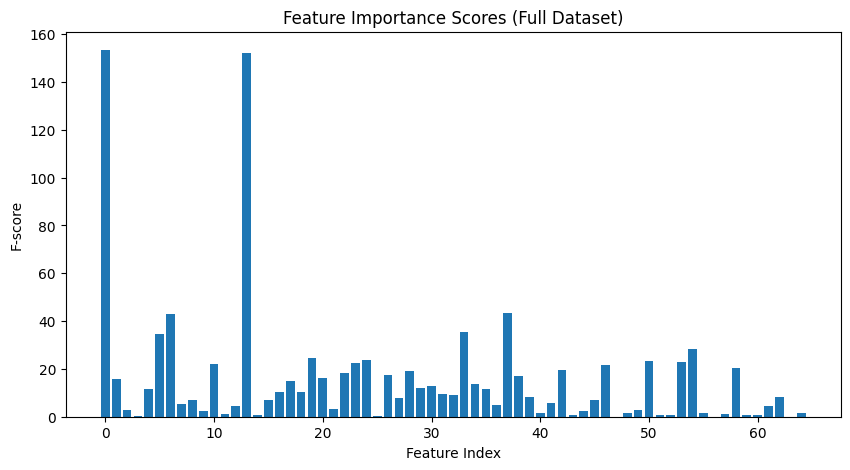

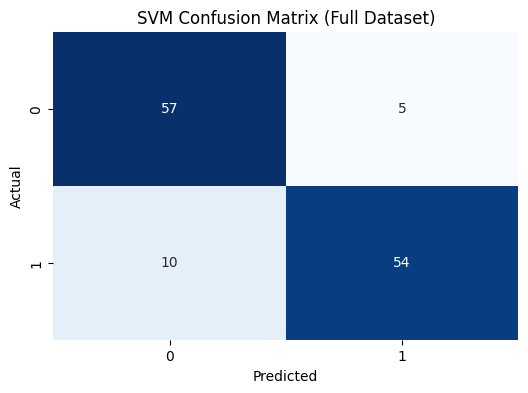


=== Random Forest Overall Metrics (Trained on Full Dataset) ===
Overall Confusion Matrix:
[[62  0]
 [ 0 64]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        64

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



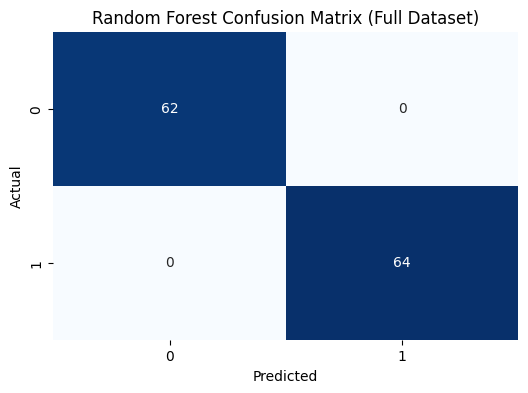


=== ANN Overall Metrics (Trained on Full Dataset) ===
Overall Confusion Matrix:
[[58  4]
 [14 50]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        62
           1       0.93      0.78      0.85        64

    accuracy                           0.86       126
   macro avg       0.87      0.86      0.86       126
weighted avg       0.87      0.86      0.86       126



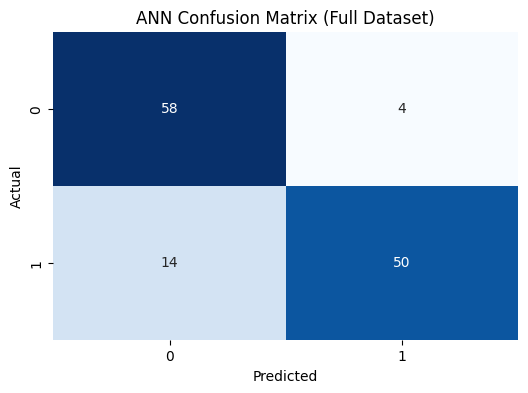


=== CNN Overall Metrics (Trained on Full Dataset) ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Overall Confusion Matrix:
[[56  6]
 [10 54]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88        62
           1       0.90      0.84      0.87        64

    accuracy                           0.87       126
   macro avg       0.87      0.87      0.87       126
weighted avg       0.87      0.87      0.87       126



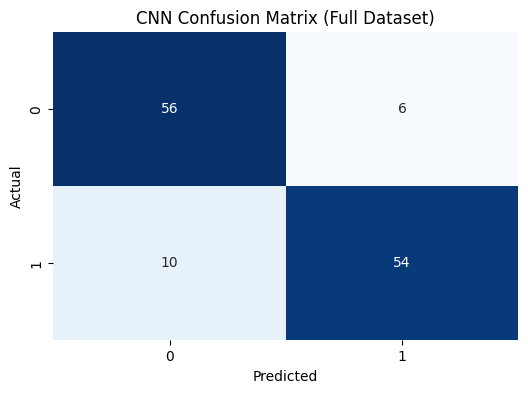

Found 920 audio files in /content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/
Found 793 COPD files and 127 non-COPD files in full dataset.
Selected subset: 126 files (64 COPD, 62 non-COPD)
Original MFCC + Wavelet Features Shape: (126, 65)
Labels Shape: (126,)
Selected Features Shape: (126, 50)
Selected Feature Indices: [ 0  1  2  4  5  6  7  8  9 10 12 13 15 16 17 18 19 20 21 22 23 24 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 49 50 53 54 58 61
 62 64]
Number of MFCC Means: 11
Number of Wavelet Features: 39

MFCC Features (Selected) and Labels (First 5 Rows):
    Feature_0   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0 -273.624969  171.313766  47.340332  18.039135   5.381822  -1.272817   
1 -478.179291  100.735161  46.928131  21.706299  25.184097  18.145760   
2 -421.932434   67.155571  57.170795  30.402742  19.548214  12.575086   
3 -275.031372  108.985306  49.949589  29.111771  25.477528  15.2

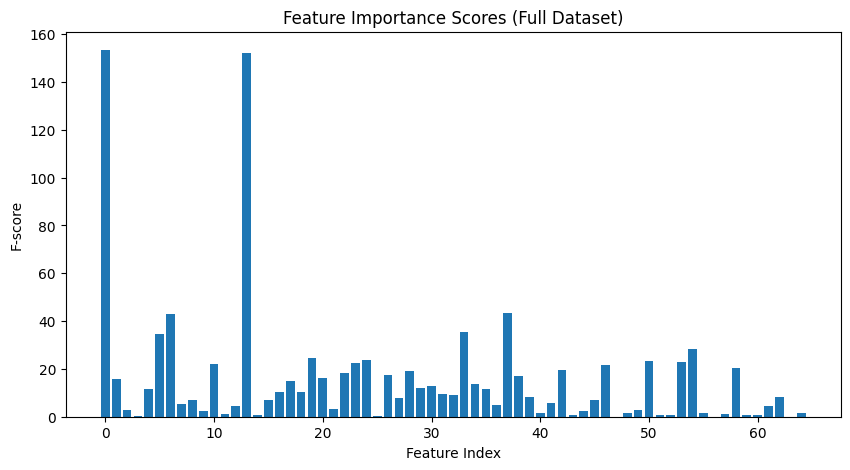

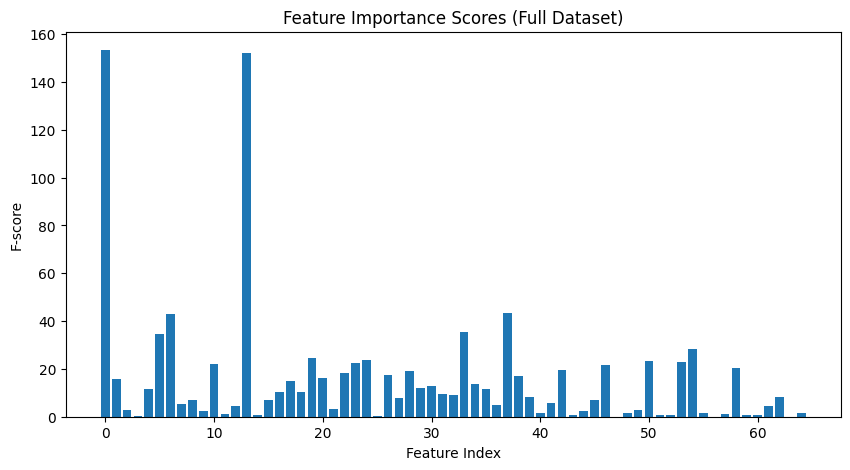

In [ ]:
# Install required libraries
!pip install librosa numpy PyWavelets scikit-learn tensorflow pandas seaborn matplotlib

# Import libraries
import os
import glob
import pandas as pd
import random
import librosa
import numpy as np
import pywt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Select the Full Dataset of 126 Samples ---

# Paths to full dataset
audio_folder = "/content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
diagnosis_file = "/content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv"

# Check if paths exist
if not os.path.exists(audio_folder):
    raise FileNotFoundError(f"Audio folder not found at {audio_folder}")
if not os.path.exists(diagnosis_file):
    raise FileNotFoundError(f"Diagnosis file not found at {diagnosis_file}")

# Load diagnosis file
diagnosis_df = pd.read_csv(diagnosis_file, header=None, names=['Patient_ID', 'Diagnosis'])

# Get .wav files
audio_files = glob.glob(os.path.join(audio_folder, "*.wav"))
print(f"Found {len(audio_files)} audio files in {audio_folder}")

# Map audio files to labels
file_label_pairs = []
for audio_file in audio_files:
    filename = os.path.basename(audio_file)
    patient_id = int(filename.split('_')[0])
    diagnosis_row = diagnosis_df[diagnosis_df['Patient_ID'] == patient_id]
    if not diagnosis_row.empty:
        diagnosis = diagnosis_row['Diagnosis'].iloc[0]
        label = 1 if diagnosis == 'COPD' else 0  # COPD: 1, non-COPD: 0
        file_label_pairs.append((audio_file, label))

# Separate into COPD and non-COPD
copd_files = [pair[0] for pair in file_label_pairs if pair[1] == 1]
non_copd_files = [pair[0] for pair in file_label_pairs if pair[1] == 0]

print(f"Found {len(copd_files)} COPD files and {len(non_copd_files)} non-COPD files in full dataset.")

# Select subset of 64 COPD and 62 non-COPD files
random.seed(42)
copd_subset = random.sample(copd_files, 64)
non_copd_subset = random.sample(non_copd_files, 62)

# Combine subsets
full_dataset = [(f, 1) for f in copd_subset] + [(f, 0) for f in non_copd_subset]

# Shuffle
random.shuffle(full_dataset)

# Separate into files and labels
full_audio_files = [pair[0] for pair in full_dataset]
full_labels = [pair[1] for pair in full_dataset]

print(f"Selected subset: {len(full_audio_files)} files ({sum(full_labels)} COPD, {len(full_labels) - sum(full_labels)} non-COPD)")

# --- Step 2: Feature Extraction and Selection ---

# Initialize lists
mfcc_features = []
labels = []

# Function to extract MFCC and apply wavelet transformation
def extract_mfcc_wavelet(file_path, num_mfcc=13, wavelet='db4'):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Standardize sample rate
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Apply wavelet transformation to MFCC
        coeffs = []
        for i in range(mfcc.shape[0]):
            cA, cD = pywt.dwt(mfcc[i], wavelet=wavelet)
            coeffs.extend([np.mean(cA), np.std(cA), np.mean(cD), np.std(cD)])

        return np.concatenate([mfcc_mean, coeffs])
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None

# Process files
for file_path, label in zip(full_audio_files, full_labels):
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(label)

# Convert to NumPy arrays
mfcc_features = np.array(mfcc_features)
labels = np.array(labels)

# Check for valid data
if mfcc_features.shape[0] == 0:
    raise ValueError("No features extracted. Check audio files or extraction process.")

print("Original MFCC + Wavelet Features Shape:", mfcc_features.shape)
print("Labels Shape:", labels.shape)

# Feature selection
num_features = min(50, mfcc_features.shape[1])  # Select up to 50 features
selector = SelectKBest(score_func=f_classif, k=num_features)
mfcc_features_selected = selector.fit_transform(mfcc_features, labels)

print("Selected Features Shape:", mfcc_features_selected.shape)

# Analyze selected features
selected_indices = selector.get_support(indices=True)
print("Selected Feature Indices:", selected_indices)

# Count MFCC means (indices 0-12)
num_mfcc_means = sum(1 for idx in selected_indices if idx < 13)

# Count wavelet features
num_wavelet = len(selected_indices) - num_mfcc_means

print(f"Number of MFCC Means: {num_mfcc_means}")
print(f"Number of Wavelet Features: {num_wavelet}")

# Create DataFrame for display
feature_columns = [f"Feature_{i}" for i in range(mfcc_features_selected.shape[1])]
df = pd.DataFrame(mfcc_features_selected, columns=feature_columns)
df['Label'] = labels

# Display DataFrame (first 5 rows for brevity)
print("\nMFCC Features (Selected) and Labels (First 5 Rows):")
print(df.head())

# Save DataFrame to CSV for reference
df.to_csv('/content/mfcc_features_selected_full.csv', index=False)
print("\nSaved features and labels to '/content/mfcc_features_selected_full.csv'")

# Visualize feature importance
scores = selector.scores_
plt.figure(figsize=(10, 5))
plt.bar(range(len(scores)), scores)
plt.title("Feature Importance Scores (Full Dataset)")
plt.xlabel("Feature Index")
plt.ylabel("F-score")
plt.savefig('/content/feature_importance_full.png')
print("\nSaved feature importance plot to '/content/feature_importance_full.png'")

# --- Step 3: Train Models with 5-Fold Cross-Validation ---

# Initialize models
svm = SVC(kernel='rbf', probability=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
ann = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

def create_cnn(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize dictionaries to store fold accuracies for each model
fold_accuracies = {
    'SVM': [],
    'Random Forest': [],
    'ANN': [],
    'CNN': []
}

# Initialize results dictionary for average metrics table
results = {
    'Model': ['SVM', 'Random Forest', 'ANN', 'CNN'],
    'Accuracy': [0.0, 0.0, 0.0, 0.0],
    'Precision': [0.0, 0.0, 0.0, 0.0],
    'Recall': [0.0, 0.0, 0.0, 0.0],
    'F1-Score': [0.0, 0.0, 0.0, 0.0]
}

# 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(skf.split(mfcc_features_selected, labels), 1):
    print(f"\n📂 Fold {fold}")
    print(f"Training indices: {train_idx}")
    print(f"Testing indices: {test_idx}")
    X_train, X_test = mfcc_features_selected[train_idx], mfcc_features_selected[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
    print(f"Training labels: {y_train}")
    print(f"Testing labels: {y_test}")

    # SVM
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    svm_accuracy = accuracy_score(y_test, y_pred_svm)
    fold_accuracies['SVM'].append(svm_accuracy)
    svm_cm = confusion_matrix(y_test, y_pred_svm)
    print(f"\nSVM Fold {fold} Accuracy: {svm_accuracy:.4f}")
    print("Confusion Matrix for Fold:")
    print(svm_cm)
    # Update metrics
    results['Accuracy'][0] += svm_accuracy
    results['Precision'][0] += precision_score(y_test, y_pred_svm, zero_division=0)
    results['Recall'][0] += recall_score(y_test, y_pred_svm, zero_division=0)
    results['F1-Score'][0] += f1_score(y_test, y_pred_svm, zero_division=0)

    # Random Forest
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    rf_accuracy = accuracy_score(y_test, y_pred_rf)
    fold_accuracies['Random Forest'].append(rf_accuracy)
    rf_cm = confusion_matrix(y_test, y_pred_rf)
    print(f"\nRandom Forest Fold {fold} Accuracy: {rf_accuracy:.4f}")
    print("Confusion Matrix for Fold:")
    print(rf_cm)
    # Update metrics
    results['Accuracy'][1] += rf_accuracy
    results['Precision'][1] += precision_score(y_test, y_pred_rf, zero_division=0)
    results['Recall'][1] += recall_score(y_test, y_pred_rf, zero_division=0)
    results['F1-Score'][1] += f1_score(y_test, y_pred_rf, zero_division=0)

    # ANN
    ann.fit(X_train, y_train)
    y_pred_ann = ann.predict(X_test)
    ann_accuracy = accuracy_score(y_test, y_pred_ann)
    fold_accuracies['ANN'].append(ann_accuracy)
    ann_cm = confusion_matrix(y_test, y_pred_ann)
    print(f"\nANN Fold {fold} Accuracy: {ann_accuracy:.4f}")
    print("Confusion Matrix for Fold:")
    print(ann_cm)
    # Update metrics
    results['Accuracy'][2] += ann_accuracy
    results['Precision'][2] += precision_score(y_test, y_pred_ann, zero_division=0)
    results['Recall'][2] += recall_score(y_test, y_pred_ann, zero_division=0)
    results['F1-Score'][2] += f1_score(y_test, y_pred_ann, zero_division=0)

    # CNN
    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    cnn = create_cnn((X_train.shape[1], 1))
    cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=16, verbose=0)
    y_pred_cnn = (cnn.predict(X_test_cnn) > 0.5).astype(int).flatten()
    cnn_accuracy = accuracy_score(y_test, y_pred_cnn)
    fold_accuracies['CNN'].append(cnn_accuracy)
    cnn_cm = confusion_matrix(y_test, y_pred_cnn)
    print(f"\nCNN Fold {fold} Accuracy: {cnn_accuracy:.4f}")
    print("Confusion Matrix for Fold:")
    print(cnn_cm)
    # Update metrics
    results['Accuracy'][3] += cnn_accuracy
    results['Precision'][3] += precision_score(y_test, y_pred_cnn, zero_division=0)
    results['Recall'][3] += recall_score(y_test, y_pred_cnn, zero_division=0)
    results['F1-Score'][3] += f1_score(y_test, y_pred_cnn, zero_division=0)

# Compute mean and standard deviation of accuracies for each model
for model_name in fold_accuracies:
    mean_accuracy = np.mean(fold_accuracies[model_name])
    std_accuracy = np.std(fold_accuracies[model_name])
    print(f"\n{model_name} Cross-validation Mean Accuracy: {mean_accuracy:.4f}")
    print(f"Standard Deviation: {std_accuracy:.4f}")

# Average metrics across folds for the results table
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    results[metric] = [x/5 for x in results[metric]]

# Create and display table
results_df = pd.DataFrame(results)
print("\nFull Dataset Results (Average over 5 folds):")
print(results_df)

# Train each model on the full dataset and display overall metrics
models = {
    'SVM': svm,
    'Random Forest': rf,
    'ANN': ann,
    'CNN': None  # CNN will be created separately
}

for model_name in models:
    print(f"\n=== {model_name} Overall Metrics (Trained on Full Dataset) ===")
    if model_name == 'CNN':
        X_cnn = mfcc_features_selected.reshape(mfcc_features_selected.shape[0], mfcc_features_selected.shape[1], 1)
        model = create_cnn((mfcc_features_selected.shape[1], 1))
        model.fit(X_cnn, labels, epochs=10, batch_size=16, verbose=0)
        y_pred = (model.predict(X_cnn) > 0.5).astype(int).flatten()
    else:
        model = models[model_name]
        model.fit(mfcc_features_selected, labels)
        y_pred = model.predict(mfcc_features_selected)

    # Overall confusion matrix
    cm = confusion_matrix(labels, y_pred)
    print("Overall Confusion Matrix:")
    print(cm)

    # Classification report
    print("Classification Report:")
    print(classification_report(labels, y_pred, zero_division=0))

    # Plot confusion matrix
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False) # Removed color bar for better visibility
    plt.title(f"{model_name} Confusion Matrix (Full Dataset)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
# Install required libraries
!pip install librosa numpy PyWavelets scikit-learn tensorflow pandas seaborn matplotlib

# Import libraries
import os
import glob
import pandas as pd
import random
import librosa
import numpy as np
import pywt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Select the Full Dataset of 126 Samples ---

# Paths to full dataset
audio_folder = "/content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
diagnosis_file = "/content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv"

# Check if paths exist
if not os.path.exists(audio_folder):
    raise FileNotFoundError(f"Audio folder not found at {audio_folder}")
if not os.path.exists(diagnosis_file):
    raise FileNotFoundError(f"Diagnosis file not found at {diagnosis_file}")

# Load diagnosis file
diagnosis_df = pd.read_csv(diagnosis_file, header=None, names=['Patient_ID', 'Diagnosis'])

# Get .wav files
audio_files = glob.glob(os.path.join(audio_folder, "*.wav"))
print(f"Found {len(audio_files)} audio files in {audio_folder}")

# Map audio files to labels
file_label_pairs = []
for audio_file in audio_files:
    filename = os.path.basename(audio_file)
    patient_id = int(filename.split('_')[0])
    diagnosis_row = diagnosis_df[diagnosis_df['Patient_ID'] == patient_id]
    if not diagnosis_row.empty:
        diagnosis = diagnosis_row['Diagnosis'].iloc[0]
        label = 1 if diagnosis == 'COPD' else 0  # COPD: 1, non-COPD: 0
        file_label_pairs.append((audio_file, label))

# Separate into COPD and non-COPD
copd_files = [pair[0] for pair in file_label_pairs if pair[1] == 1]
non_copd_files = [pair[0] for pair in file_label_pairs if pair[1] == 0]

print(f"Found {len(copd_files)} COPD files and {len(non_copd_files)} non-COPD files in full dataset.")

# Select subset of 64 COPD and 62 non-COPD files
random.seed(42)
copd_subset = random.sample(copd_files, 64)
non_copd_subset = random.sample(non_copd_files, 62)

# Combine subsets
full_dataset = [(f, 1) for f in copd_subset] + [(f, 0) for f in non_copd_subset]

# Shuffle
random.shuffle(full_dataset)

# Separate into files and labels
full_audio_files = [pair[0] for pair in full_dataset]
full_labels = [pair[1] for pair in full_dataset]

print(f"Selected subset: {len(full_audio_files)} files ({sum(full_labels)} COPD, {len(full_labels) - sum(full_labels)} non-COPD)")

# --- Step 2: Feature Extraction and Selection ---

# Initialize lists
mfcc_features = []
labels = []

# Function to extract MFCC and apply wavelet transformation
def extract_mfcc_wavelet(file_path, num_mfcc=13, wavelet='db4'):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Standardize sample rate
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Apply wavelet transformation to MFCC
        coeffs = []
        for i in range(mfcc.shape[0]):
            cA, cD = pywt.dwt(mfcc[i], wavelet=wavelet)
            coeffs.extend([np.mean(cA), np.std(cA), np.mean(cD), np.std(cD)])

        return np.concatenate([mfcc_mean, coeffs])
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None

# Process files
for file_path, label in zip(full_audio_files, full_labels):
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(label)

# Convert to NumPy arrays
mfcc_features = np.array(mfcc_features)
labels = np.array(labels)

# Check for valid data
if mfcc_features.shape[0] == 0:
    raise ValueError("No features extracted. Check audio files or extraction process.")

print("Original MFCC + Wavelet Features Shape:", mfcc_features.shape)
print("Labels Shape:", labels.shape)

# Feature selection
num_features = min(50, mfcc_features.shape[1])  # Select up to 50 features
selector = SelectKBest(score_func=f_classif, k=num_features)
mfcc_features_selected = selector.fit_transform(mfcc_features, labels)

print("Selected Features Shape:", mfcc_features_selected.shape)

# Analyze selected features
selected_indices = selector.get_support(indices=True)
print("Selected Feature Indices:", selected_indices)

# Count MFCC means (indices 0-12)
num_mfcc_means = sum(1 for idx in selected_indices if idx < 13)

# Count wavelet features
num_wavelet = len(selected_indices) - num_mfcc_means

print(f"Number of MFCC Means: {num_mfcc_means}")
print(f"Number of Wavelet Features: {num_wavelet}")

# Create DataFrame for display
feature_columns = [f"Feature_{i}" for i in range(mfcc_features_selected.shape[1])]
df = pd.DataFrame(mfcc_features_selected, columns=feature_columns)
df['Label'] = labels

# Display DataFrame (first 5 rows for brevity)
print("\nMFCC Features (Selected) and Labels (First 5 Rows):")
print(df.head())

# Save DataFrame to CSV for reference
df.to_csv('/content/mfcc_features_selected_full.csv', index=False)
print("\nSaved features and labels to '/content/mfcc_features_selected_full.csv'")

# Visualize feature importance
scores = selector.scores_
plt.figure(figsize=(10, 5))
plt.bar(range(len(scores)), scores)
plt.title("Feature Importance Scores (Full Dataset)")
plt.xlabel("Feature Index")
plt.ylabel("F-score")
plt.savefig('/content/feature_importance_full.png')
print("\nSaved feature importance plot to '/content/feature_importance_full.png'")

# --- Step 3: Train Models with 5-Fold Cross-Validation ---

# Initialize models
svm = SVC(kernel='rbf', probability=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
ann = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

def create_cnn(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize

# Import libraries
import os
import glob
import pandas as pd
import random
import librosa
import numpy as np
import pywt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Select the Full Dataset of 126 Samples ---

# Paths to full dataset
audio_folder = "/content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
diagnosis_file = "/content/drive/MyDrive/KaggleDatasets/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv"

# Check if paths exist
if not os.path.exists(audio_folder):
    raise FileNotFoundError(f"Audio folder not found at {audio_folder}")
if not os.path.exists(diagnosis_file):
    raise FileNotFoundError(f"Diagnosis file not found at {diagnosis_file}")

# Load diagnosis file
diagnosis_df = pd.read_csv(diagnosis_file, header=None, names=['Patient_ID', 'Diagnosis'])

# Get .wav files
audio_files = glob.glob(os.path.join(audio_folder, "*.wav"))
print(f"Found {len(audio_files)} audio files in {audio_folder}")

# Map audio files to labels
file_label_pairs = []
for audio_file in audio_files:
    filename = os.path.basename(audio_file)
    patient_id = int(filename.split('_')[0])
    diagnosis_row = diagnosis_df[diagnosis_df['Patient_ID'] == patient_id]
    if not diagnosis_row.empty:
        diagnosis = diagnosis_row['Diagnosis'].iloc[0]
        label = 1 if diagnosis == 'COPD' else 0  # COPD: 1, non-COPD: 0
        file_label_pairs.append((audio_file, label))

# Separate into COPD and non-COPD
copd_files = [pair[0] for pair in file_label_pairs if pair[1] == 1]
non_copd_files = [pair[0] for pair in file_label_pairs if pair[1] == 0]

print(f"Found {len(copd_files)} COPD files and {len(non_copd_files)} non-COPD files in full dataset.")

# Select subset of 64 COPD and 62 non-COPD files
random.seed(42)
copd_subset = random.sample(copd_files, 64)
non_copd_subset = random.sample(non_copd_files, 62)

# Combine subsets
full_dataset = [(f, 1) for f in copd_subset] + [(f, 0) for f in non_copd_subset]

# Shuffle
random.shuffle(full_dataset)

# Separate into files and labels
full_audio_files = [pair[0] for pair in full_dataset]
full_labels = [pair[1] for pair in full_dataset]

print(f"Selected subset: {len(full_audio_files)} files ({sum(full_labels)} COPD, {len(full_labels) - sum(full_labels)} non-COPD)")

# --- Step 2: Feature Extraction and Selection ---

# Initialize lists
mfcc_features = []
labels = []

# Function to extract MFCC and apply wavelet transformation
def extract_mfcc_wavelet(file_path, num_mfcc=13, wavelet='db4'):
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Standardize sample rate
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)

        # Apply wavelet transformation to MFCC
        coeffs = []
        for i in range(mfcc.shape[0]):
            cA, cD = pywt.dwt(mfcc[i], wavelet=wavelet)
            coeffs.extend([np.mean(cA), np.std(cA), np.mean(cD), np.std(cD)])

        return np.concatenate([mfcc_mean, coeffs])
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None

# Process files
for file_path, label in zip(full_audio_files, full_labels):
    features = extract_mfcc_wavelet(file_path)
    if features is not None:
        mfcc_features.append(features)
        labels.append(label)

# Convert to NumPy arrays
mfcc_features = np.array(mfcc_features)
labels = np.array(labels)

# Check for valid data
if mfcc_features.shape[0] == 0:
    raise ValueError("No features extracted. Check audio files or extraction process.")

print("Original MFCC + Wavelet Features Shape:", mfcc_features.shape)
print("Labels Shape:", labels.shape)

# Feature selection
num_features = min(50, mfcc_features.shape[1])  # Select up to 50 features
selector = SelectKBest(score_func=f_classif, k=num_features)
mfcc_features_selected = selector.fit_transform(mfcc_features, labels)

print("Selected Features Shape:", mfcc_features_selected.shape)

# Analyze selected features
selected_indices = selector.get_support(indices=True)
print("Selected Feature Indices:", selected_indices)

# Count MFCC means (indices 0-12)
num_mfcc_means = sum(1 for idx in selected_indices if idx < 13)

# Count wavelet features
num_wavelet = len(selected_indices) - num_mfcc_means

print(f"Number of MFCC Means: {num_mfcc_means}")
print(f"Number of Wavelet Features: {num_wavelet}")

# Create DataFrame for display
feature_columns = [f"Feature_{i}" for i in range(mfcc_features_selected.shape[1])]
df = pd.DataFrame(mfcc_features_selected, columns=feature_columns)
df['Label'] = labels

# Display DataFrame (first 5 rows for brevity)
print("\nMFCC Features (Selected) and Labels (First 5 Rows):")
print(df.head())

# Save DataFrame to CSV for reference
df.to_csv('/content/mfcc_features_selected_full.csv', index=False)
print("\nSaved features and labels to '/content/mfcc_features_selected_full.csv'")

# Visualize feature importance
scores = selector.scores_
plt.figure(figsize=(10, 5))
plt.bar(range(len(scores)), scores)
plt.title("Feature Importance Scores (Full Dataset)")
plt.xlabel("Feature Index")
plt.ylabel("F-score")
plt.savefig('/content/feature_importance_full.png')
print("\nSaved feature importance plot to '/content/feature_importance_full.png'")

# --- Step 3: Train Models with 5-Fold Cross-Validation ---

# Initialize models
svm = SVC(kernel='rbf', probability=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
ann = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

def create_cnn(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize